In [16]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
#* magic to add python path to notebook environment
import sys
pypath = sys.path[0]
%env PYTHONPATH $pypath

import awkward as ak
import numpy as np
from python.analysis import cross_section, Plots, Tags, PFOSelection

from apps import cex_analysis_input

cross_section.SetPlotStyle(dark = False, extend_colors = True, dpi = 100)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
env: PYTHONPATH=/home/sb16165/Documents/pi0-analysis/analysis


In [2]:
args = cross_section.ApplicationArguments.ResolveConfig(cross_section.LoadConfiguration("work/2023/cex_analysis_2GeV_config.json"))

In [3]:
mc = cross_section.Data(args.mc_file, nTuple_type = cross_section.Ntuple_Type.PDSP, target_momentum = args.pmom)

In [4]:
mc_beam = cex_analysis_input.BeamPionSelection(mc, args, True)

'BeamPionSelection' executed in 0.0163s

In [5]:
reco_regions, true_regions = cex_analysis_input.RegionSelection(mc, args, True)

'RegionSelection' executed in 4.6874s

In [6]:
def visualise_bar(v, reco_region : str, label : str):
    Plots.PlotBar(v[reco_regions[reco_region]], xlabel = f"{label} n PFOs in {cross_section.remove_(reco_region)} region")

    bars = {}
    for _, t in Plots.IterMultiPlot(true_regions):
        mask = reco_regions[reco_region] & true_regions[t]
        i, c = np.unique(v[mask], return_counts = True)
        bars[t] = [i, c/sum(c)]

        Plots.PlotBar(v[mask], xlabel = f"{label} in {cross_section.remove_(reco_region)} region", title = cross_section.remove_(t), newFigure = False)

    Plots.PlotStackedBar(list(bars.values()), list(bars.keys()))
    return

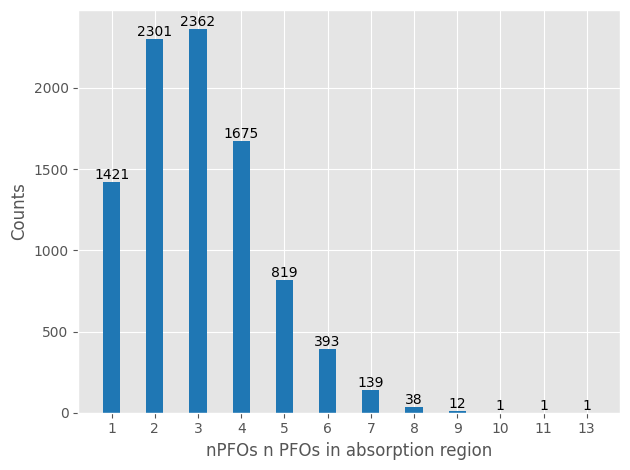

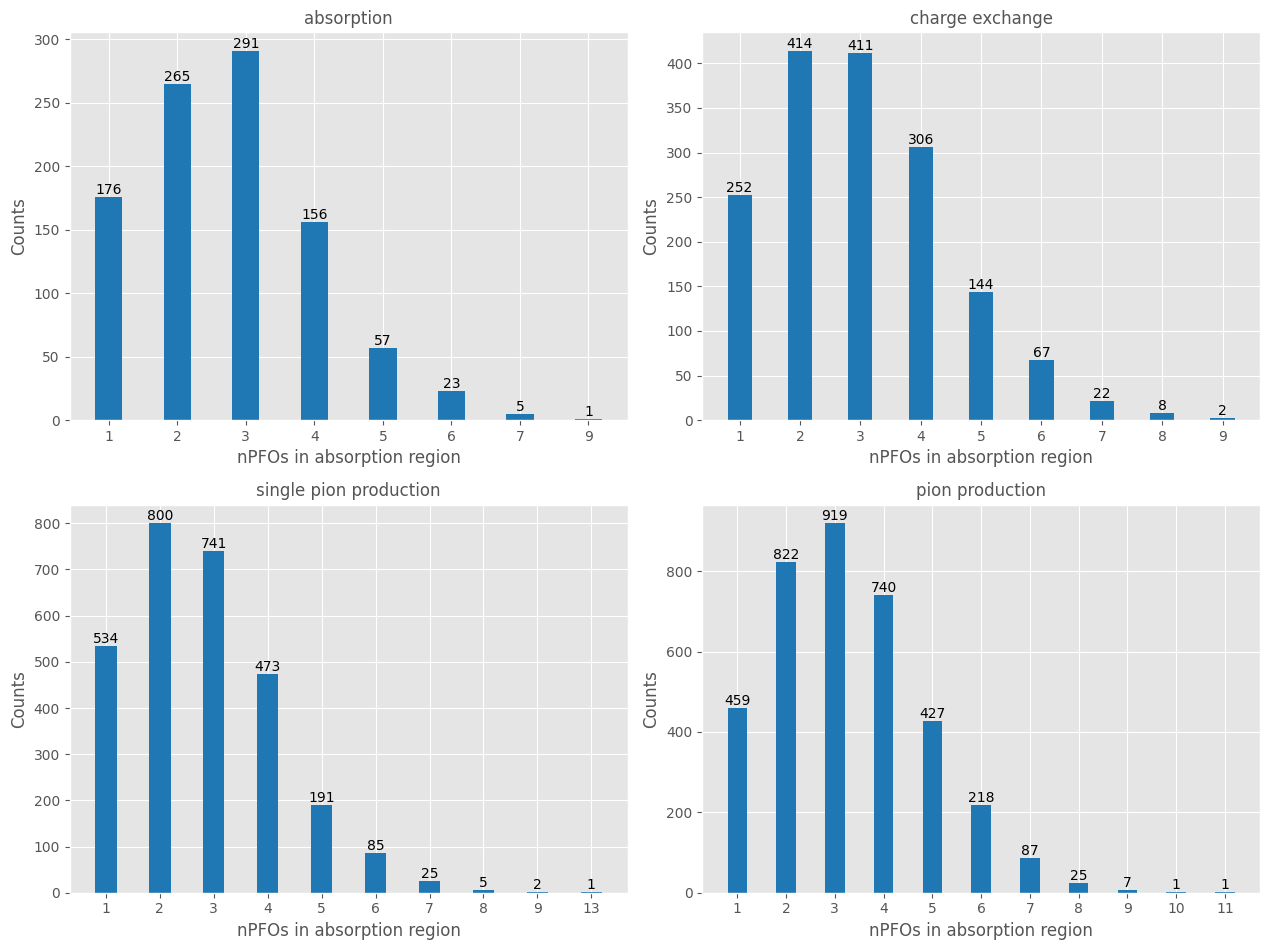

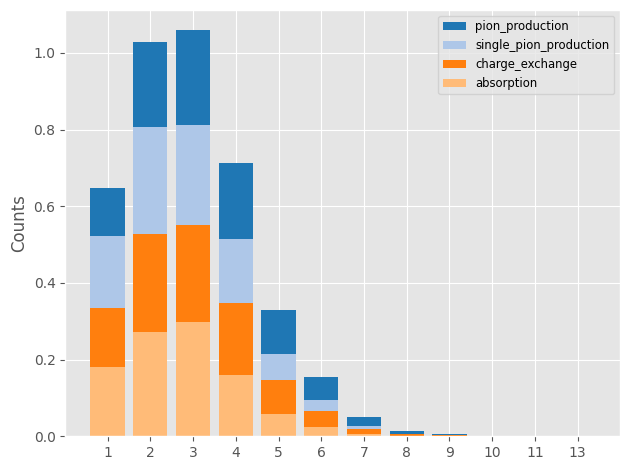

In [7]:
visualise_bar(ak.num(mc_beam.recoParticles.number), "absorption", "nPFOs")

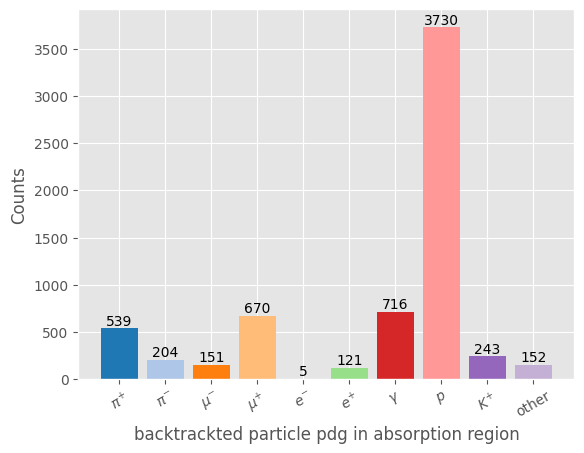

In [8]:
true_particle_tags = Tags.GenerateTrueParticleTags(mc_beam)
for t in true_particle_tags:
    true_particle_tags[t].mask = true_particle_tags[t].mask & true_regions["absorption"]
Plots.PlotTags(true_particle_tags, xlabel = "backtrackted particle pdg in absorption region")

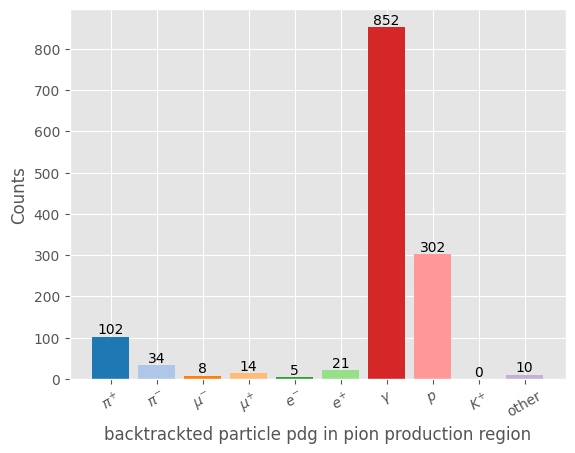

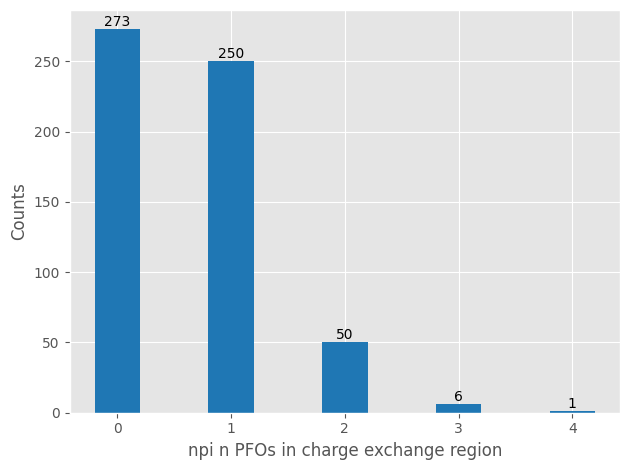

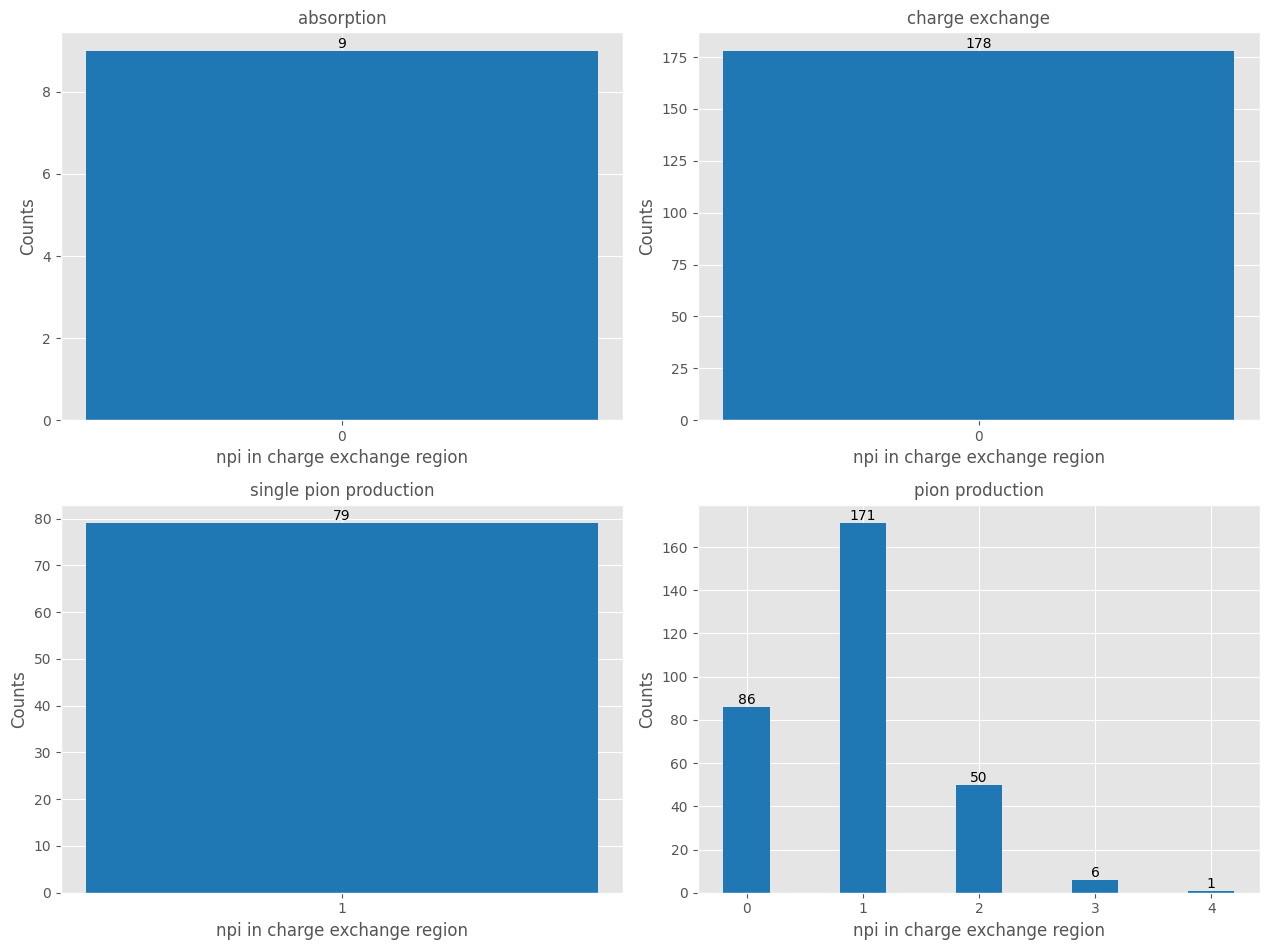

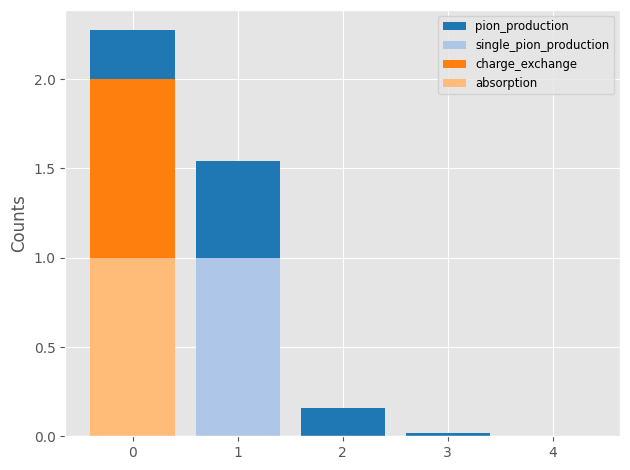

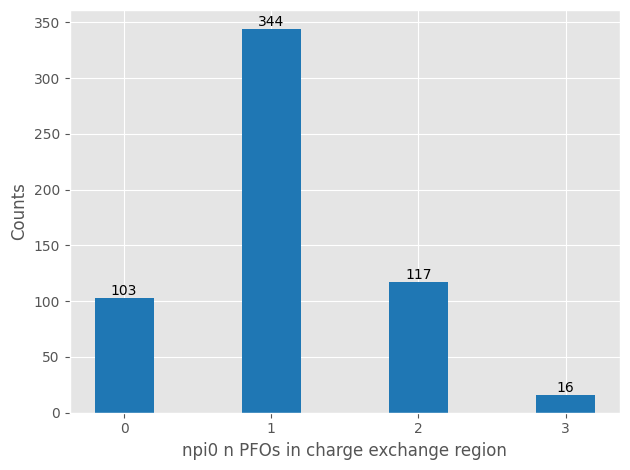

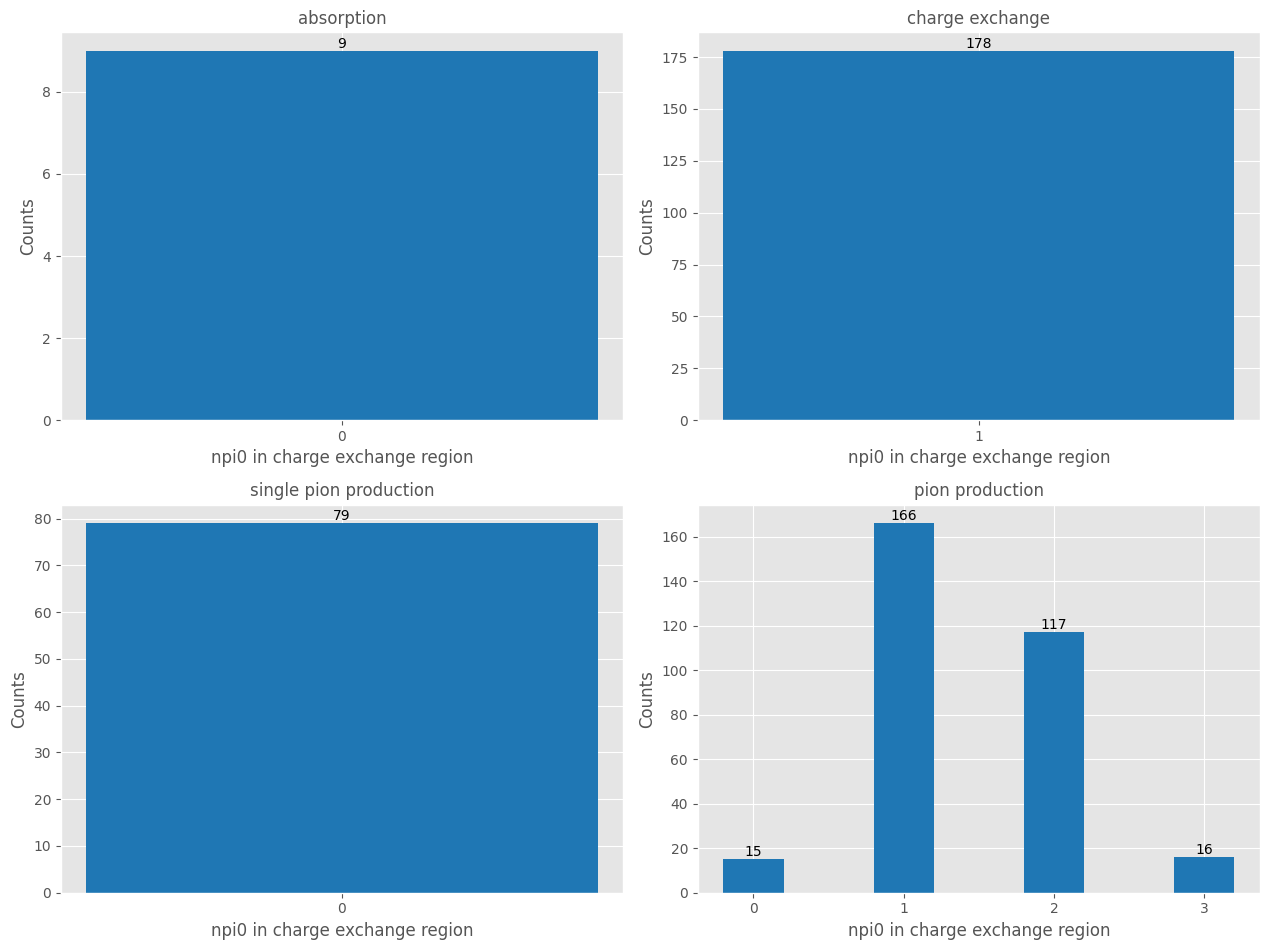

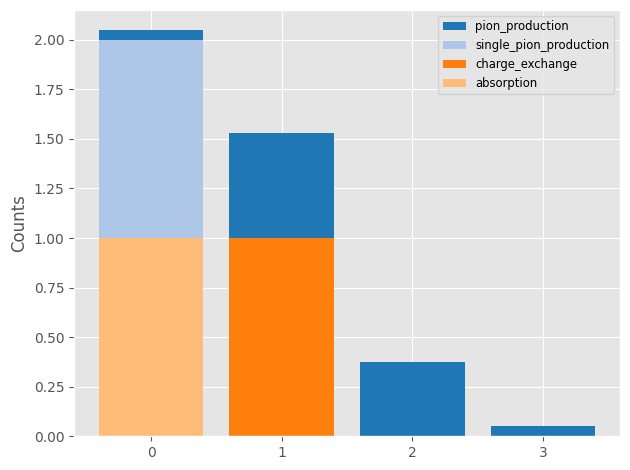

In [9]:
true_particle_tags = Tags.GenerateTrueParticleTags(mc_beam)
for t in true_particle_tags:
    true_particle_tags[t].mask = true_particle_tags[t].mask & true_regions["pion_production"] & reco_regions["charge_exchange"]
Plots.PlotTags(true_particle_tags, xlabel = "backtrackted particle pdg in pion production region")

visualise_bar(mc_beam.trueParticles.nPiPlus + mc_beam.trueParticles.nPiMinus, "charge_exchange", "npi")
visualise_bar(mc_beam.trueParticles.nPi0, "charge_exchange", "npi0")

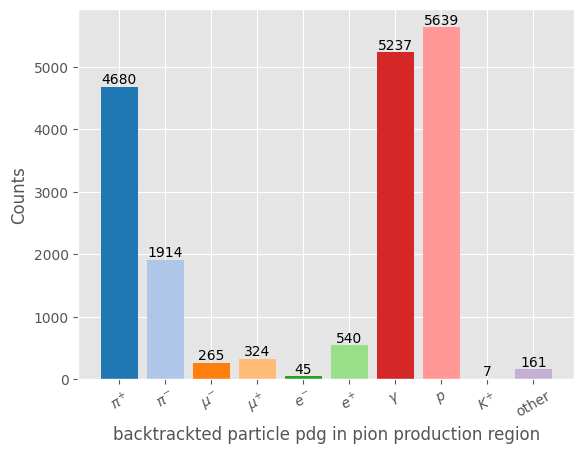

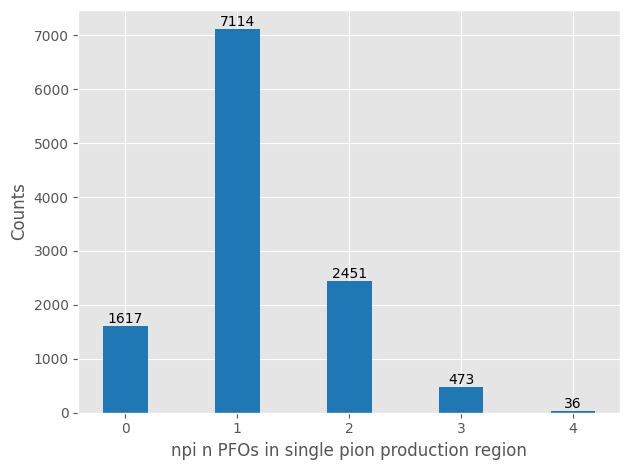

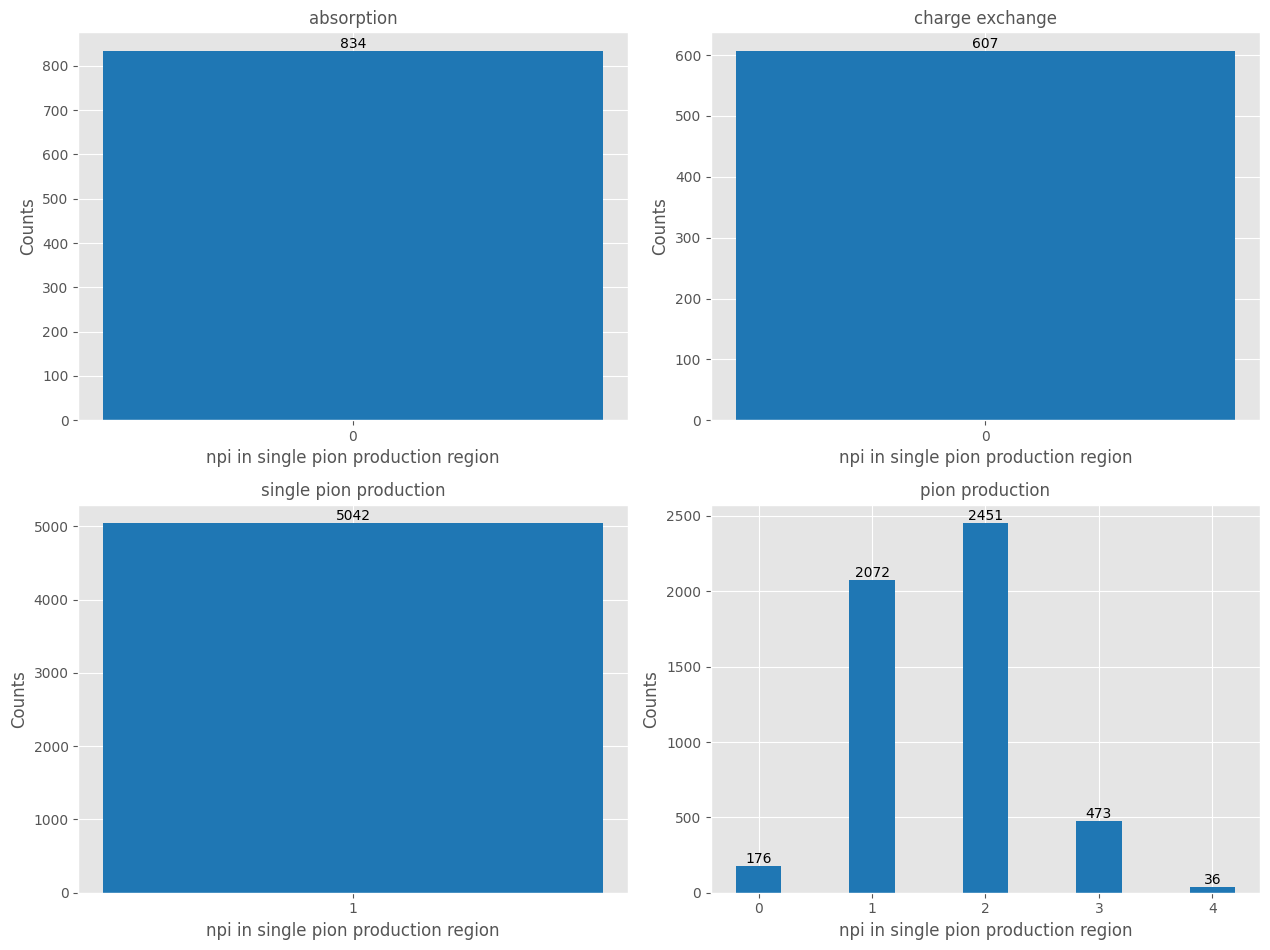

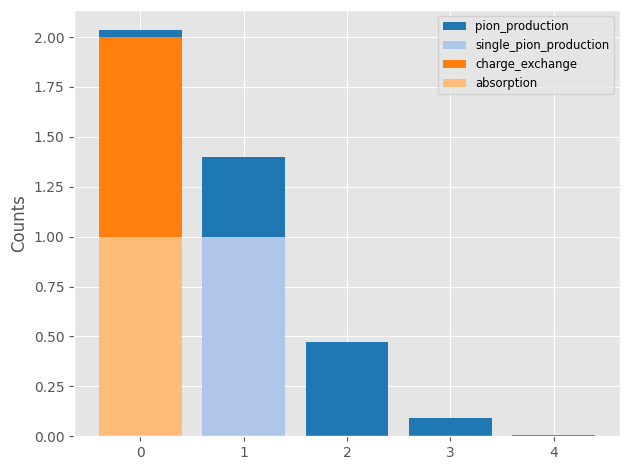

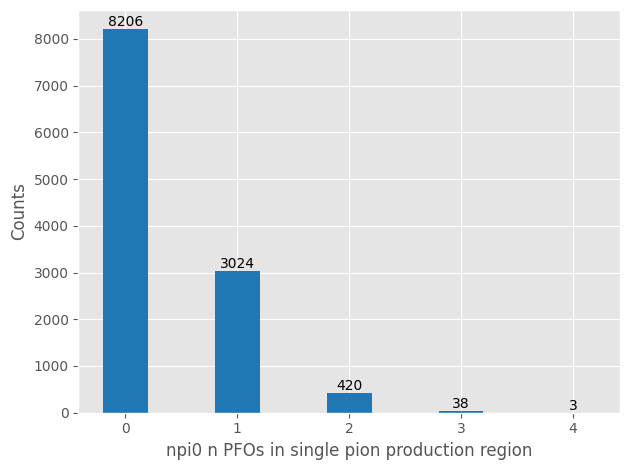

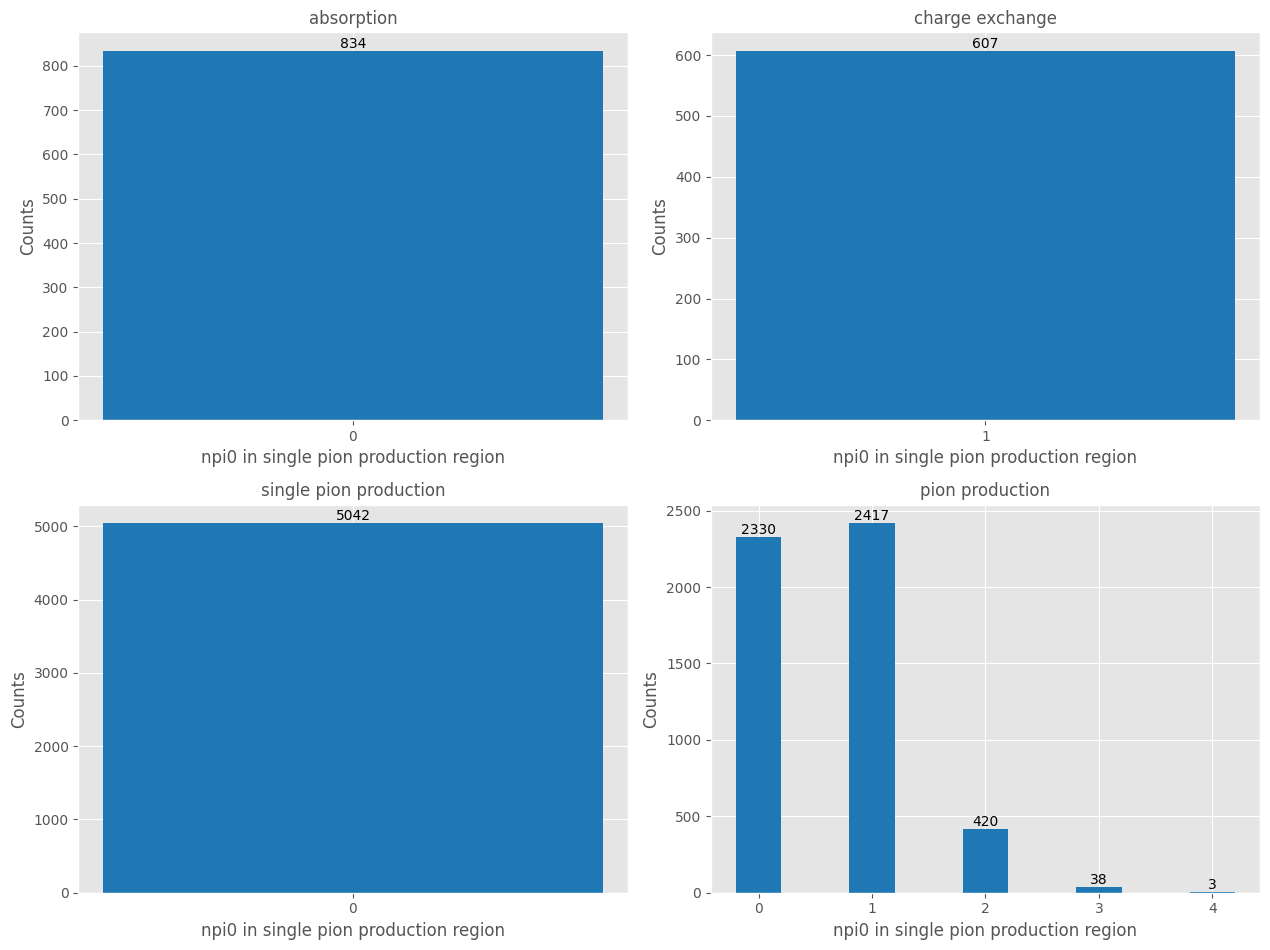

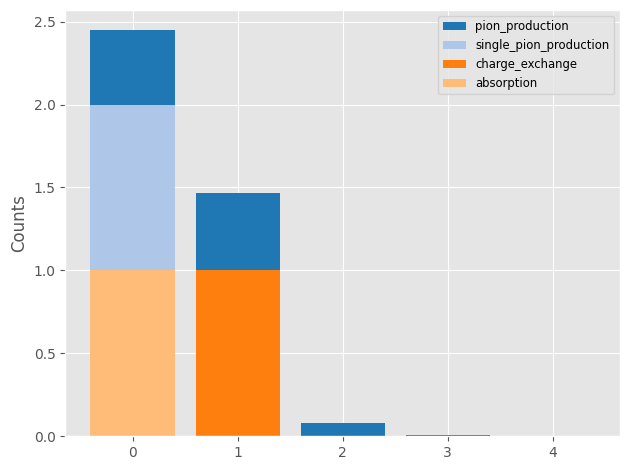

In [10]:
true_particle_tags = Tags.GenerateTrueParticleTags(mc_beam)
for t in true_particle_tags:
    true_particle_tags[t].mask = true_particle_tags[t].mask & true_regions["pion_production"] & reco_regions["single_pion_production"]
Plots.PlotTags(true_particle_tags, xlabel = "backtrackted particle pdg in pion production region")

visualise_bar(mc_beam.trueParticles.nPiPlus + mc_beam.trueParticles.nPiMinus, "single_pion_production", "npi")
visualise_bar(mc_beam.trueParticles.nPi0, "single_pion_production", "npi0")

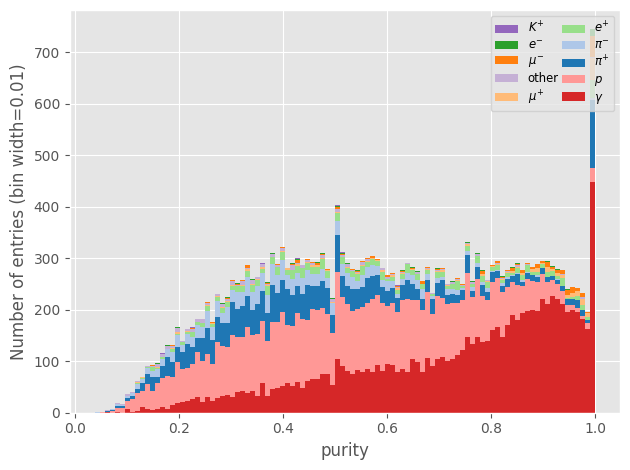

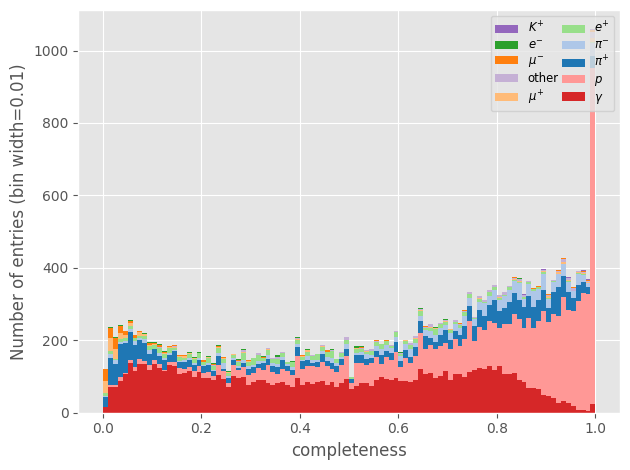

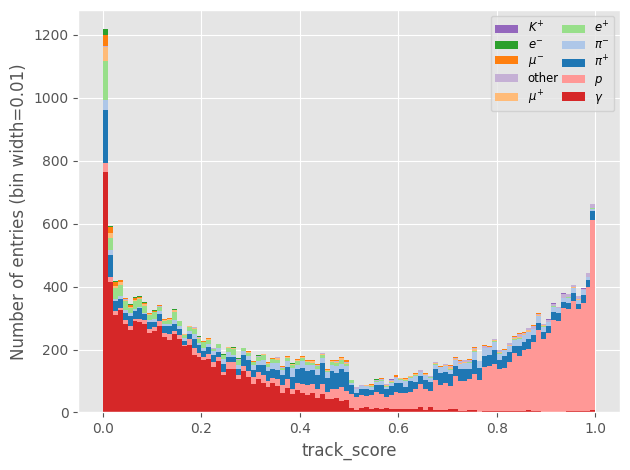

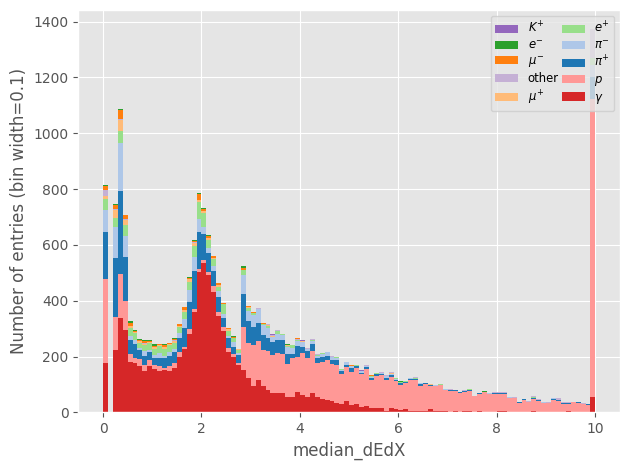

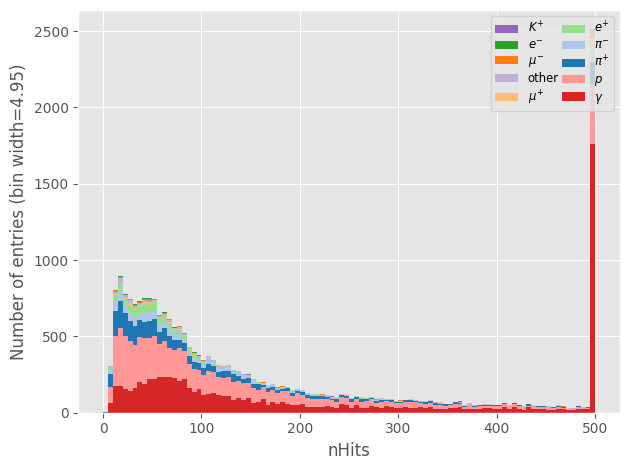

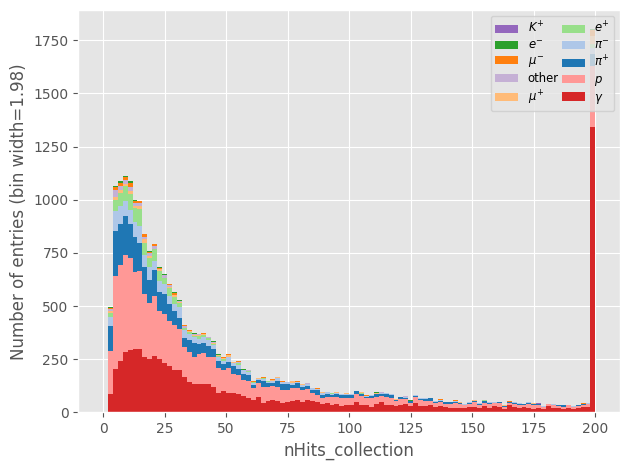

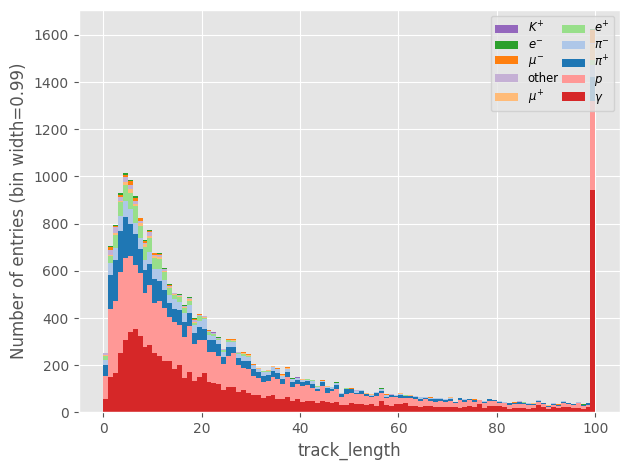

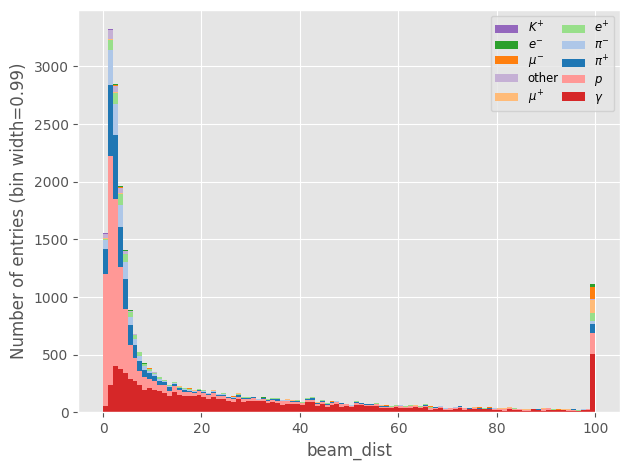

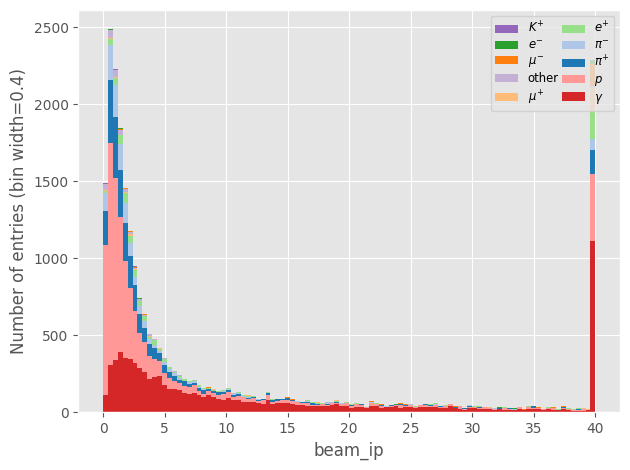

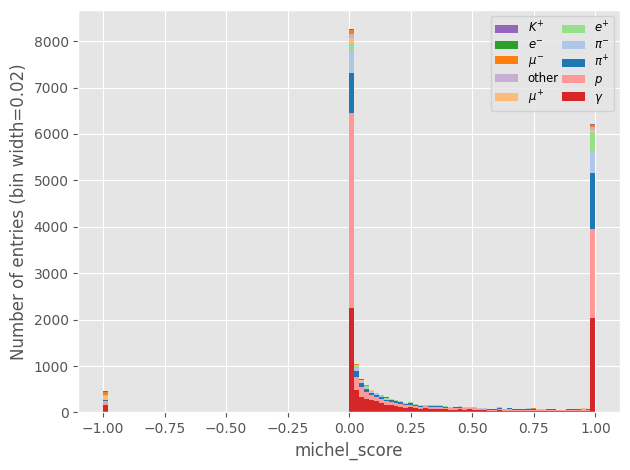

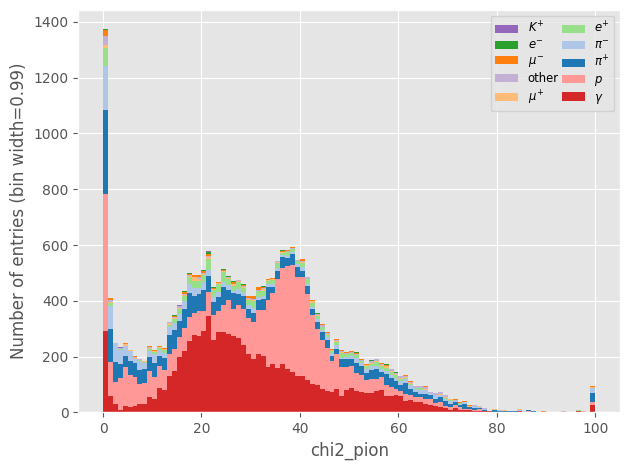

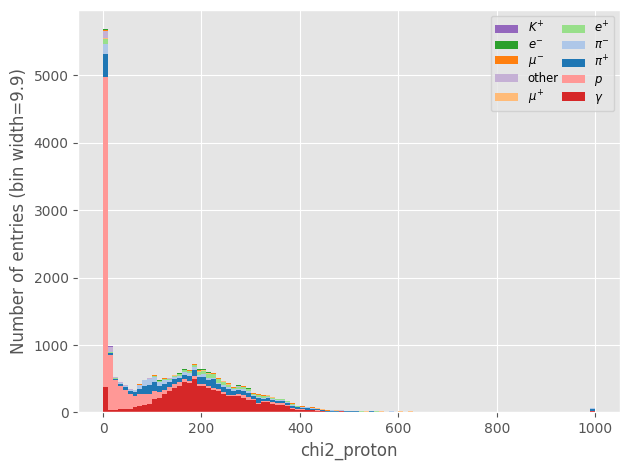

In [246]:
daughter_pi_mask = SelectionTools.CombineMasks(args.selection_masks["mc"]["pi"])
mask = true_regions["pion_production"] & (reco_regions["charge_exchange"] | reco_regions["single_pion_production"] | reco_regions["absorption"]) & ((mc_beam.trueParticles.nPiPlus + mc_beam.trueParticles.nPiMinus) > 0)

mask = mask & (~daughter_pi_mask)

tags = Tags.GenerateTrueParticleTags(mc_beam)

for t in tags:
    tags[t].mask = tags[t].mask[mask]

observables = {
    "purity" : mc_beam.trueParticlesBT.purity,
    "completeness" : mc_beam.trueParticlesBT.completeness,
    "track_score" : PFOSelection.TrackScoreCut(mc_beam, return_property = True)[1],
    "median_dEdX" : PFOSelection.PiPlusSelection(mc_beam, return_property = True)[1],
    "nHits" : PFOSelection.NHitsCut(mc_beam, return_property = True)[1],
    "nHits_collection" : mc_beam.recoParticles.n_hits_collection,
    "track_length" : mc_beam.recoParticles.track_len,
    "beam_dist" : PFOSelection.BeamParticleDistanceCut(mc_beam, return_property = True)[1],
    "beam_ip" : PFOSelection.BeamParticleIPCut(mc_beam, return_property = True)[1],
    "michel_score" : mc_beam.recoParticles.track_vertex_michel,
    "chi2_pion" : mc_beam.recoParticles.track_chi2_pion / mc_beam.recoParticles.track_chi2_pion_ndof,
    "chi2_proton" : mc_beam.recoParticles.track_chi2_proton / mc_beam.recoParticles.track_chi2_proton_ndof
}

ranges = {
    "purity"           : None,
    "completeness"     : None,
    "track_score"      : None,
    "median_dEdX"      : [0, 10],
    "nHits"            : [0, 500],
    "nHits_collection" : [0, 200],
    "track_length"     : [0, 100],
    "beam_dist"        : [0, 100],
    "beam_ip"          : [0, 40],
    "michel_score"     : [-1, 1],
    "chi2_pion"        : [0, 100],
    "chi2_proton"      : [0, 1000]
}

for (n, o), r in zip(observables.items(), ranges.values()):
    Plots.PlotTagged(o[mask], tags, x_label = n, x_range = r, truncate = r is not None)

In [247]:
pi = (tags.number[0].mask) | (tags.number[1].mask)
gamma = tags.number[6].mask
p = tags.number[7].mask

In [248]:
class CutOptimiser:
    def __init__(self, x : ak.Array, signal : ak.Array, n_cuts : int = 1, n_step = 50, x_range = None) -> None:
        self.x = x
        self.signal = signal
        self.n_cuts = n_cuts
        self.n_step = n_step
        self.x_range = x_range
        pass

    def p(self, selected_signal):
        return ak.sum(selected_signal)/ak.count(selected_signal)

    def e(self, selected_signal):
        return ak.sum(selected_signal)/ak.count(self.signal)

    def pe(self, selected_signal):
        return self.p(selected_signal) * self.e(selected_signal)

    def sb(self, selected_signal):
        return ak.sum(selected_signal) / ak.sum(~selected_signal)

    def ssb(self, selected_signal):
        return ak.sum(selected_signal) / np.sqrt(ak.sum(~selected_signal))

    def Optimise(self, score : callable, plot : bool = False):
        if self.x_range is None:
            cut_values = np.linspace(ak.min(self.x), ak.max(self.x), self.n_step)
        else:
            cut_values = np.linspace(min(self.x_range), max(self.x_range), self.n_step)

        score_l = []
        score_g = []
        for c in cut_values:
            mask = self.x < c
            score_l.append(score(self.signal[mask]))
            score_g.append(score(self.signal[~mask]))

        max_l = np.nanargmax(score_l)
        max_g = np.nanargmax(score_g)
        
        if score_l[max_l] > score_g[max_g]:
            op = "<"
            cut_value = cut_values[max_l]
        else:
            op = ">"
            cut_value = cut_values[max_g]

        if plot is True:
            Plots.Plot(cut_values, score_l, xlabel = "cut value", ylabel = "score", label = "x < c", newFigure = False)
            Plots.Plot(cut_values, score_g, label = "x > c", newFigure = False)
            Plots.Plot(cut_values[max_l], score_l[max_l], marker = "X", newFigure = False)
            Plots.Plot(cut_values[max_g], score_g[max_g], marker = "X", newFigure = False)

        return cut_value, op

    def visualise(self, cut_value, cut_op, tags : Tags = None, x_label = None):
        if tags is None:
            tags = Tags.Tags()
            tags["signal"] = Tags.Tag(name = "signal", mask = self.signal, colour = "C6", number = 0)
            tags["background"] = Tags.Tag(name = "background", mask = ~self.signal, colour = "C0", number = 1)
        Plots.PlotTagged(self.x, tags, x_label = x_label, x_range = self.x_range, truncate = self.x_range is not None, newFigure = False)
        
        if self.x_range is None:
            l = ak.max(self.x)
        else:
            l = max(self.x_range)
        Plots.DrawCutPosition(cut_value, face = cut_op, arrow_length = 0.1 * l)

for k, v in {"pi" : pi, "p" : p, "gamma" : gamma}.items():
    with Plots.PlotBook(k) as book:
        cut_op = CutOptimiser(None, v, n_step = 25)
        for o in observables:
            cut_op.x = observables[o][mask]
            cut_op.x_range = ranges[o]
            plot = Plots.MultiPlot(2)
            next(plot)
            results = cut_op.Optimise(cut_op.pe, plot = True)
            Plots.plt.title(o)
            next(plot)
            cut_op.visualise(*results, tags = tags, x_label = o)
            book.Save()

Plots.plt.close("all")

pdf pi.pdf has been opened


/tmp/ipykernel_27328/356583949.py:11: RuntimeWarning: invalid value encountered in long_scalars
  return ak.sum(selected_signal)/ak.count(selected_signal)


pdf pi.pdf has been closed
pdf p.pdf has been opened


/tmp/ipykernel_27328/356583949.py:11: RuntimeWarning: invalid value encountered in long_scalars
  return ak.sum(selected_signal)/ak.count(selected_signal)
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Plots.py:964: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.subplots(figsize = [6.4 * dim[1], 4.8 * dim[0]])


pdf p.pdf has been closed
pdf gamma.pdf has been opened


/tmp/ipykernel_27328/356583949.py:11: RuntimeWarning: invalid value encountered in long_scalars
  return ak.sum(selected_signal)/ak.count(selected_signal)


pdf gamma.pdf has been closed


/tmp/ipykernel_27328/356583949.py:11: RuntimeWarning: invalid value encountered in long_scalars
  return ak.sum(selected_signal)/ak.count(selected_signal)
/tmp/ipykernel_27328/356583949.py:11: RuntimeWarning: invalid value encountered in long_scalars
  return ak.sum(selected_signal)/ak.count(selected_signal)


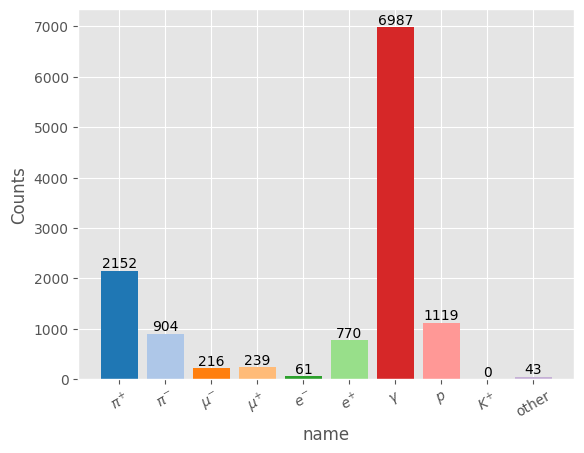

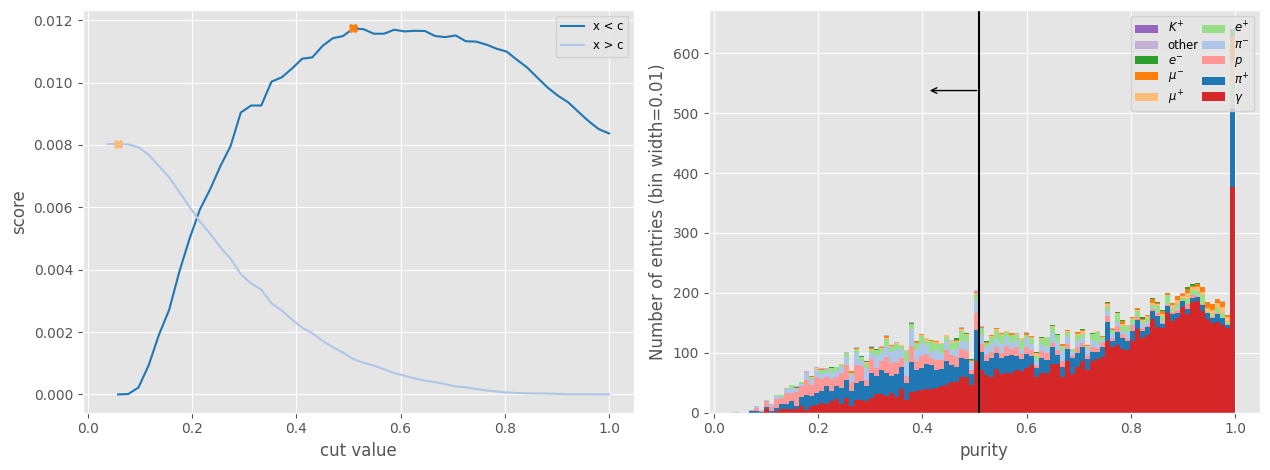

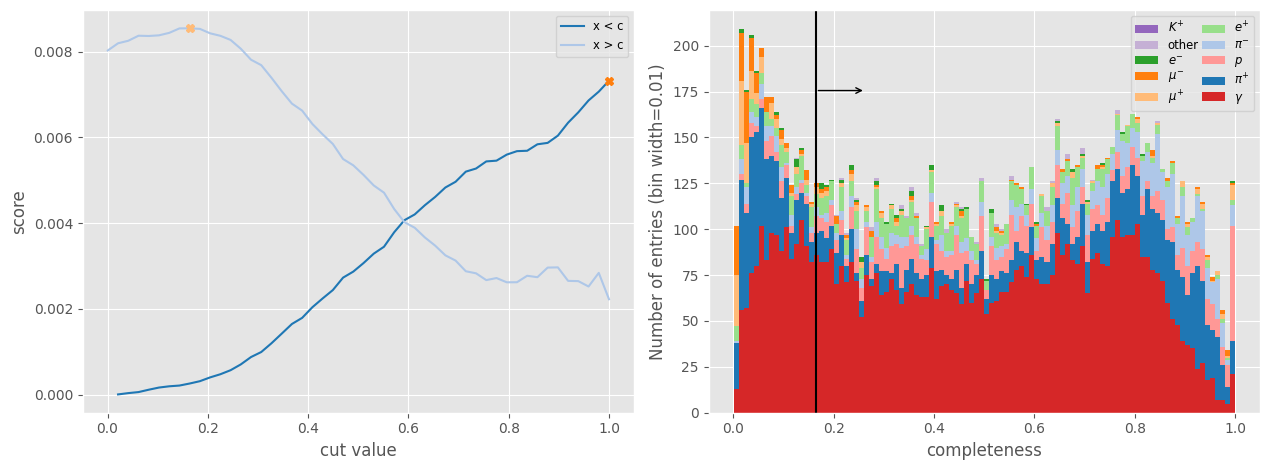

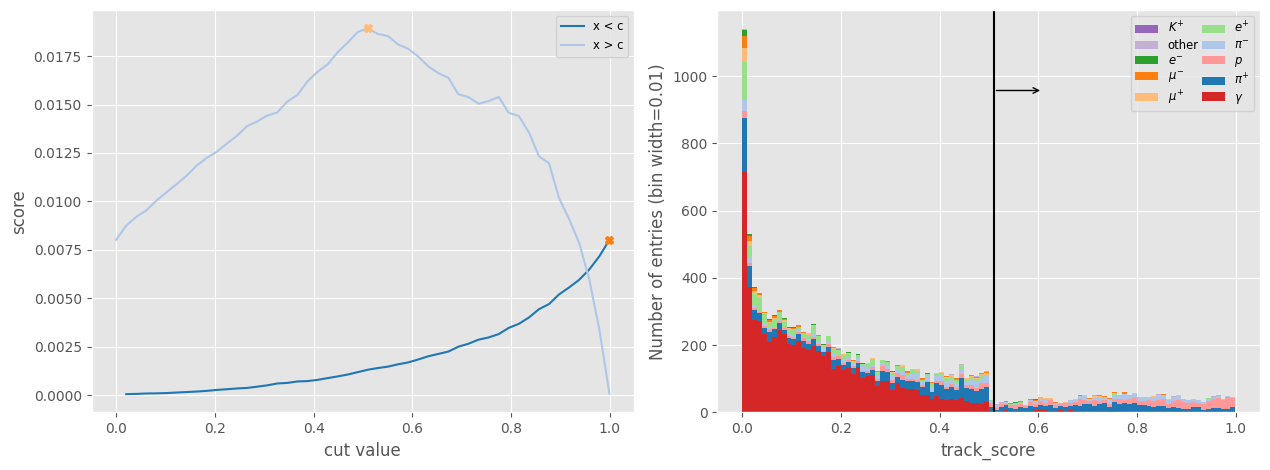

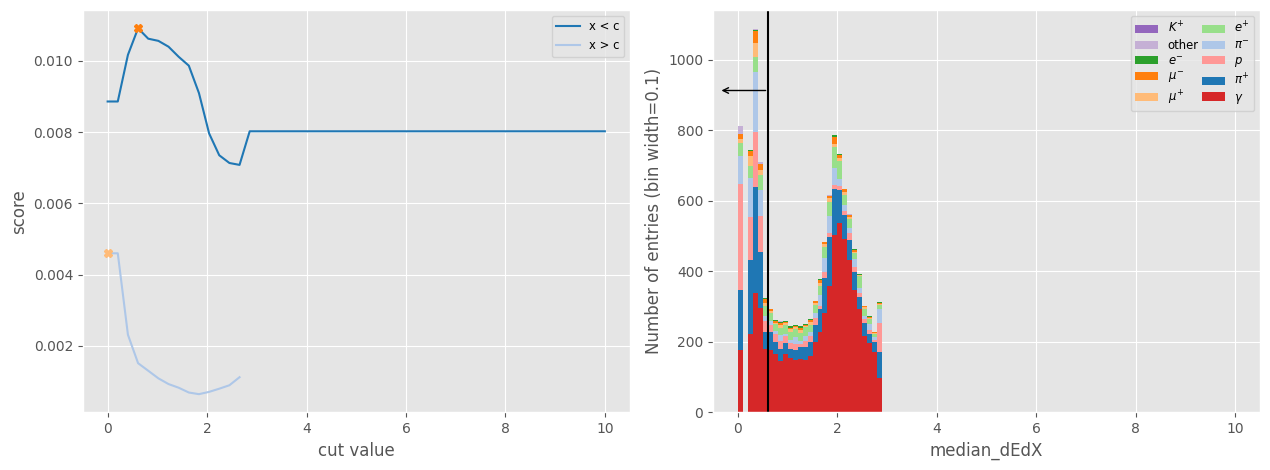

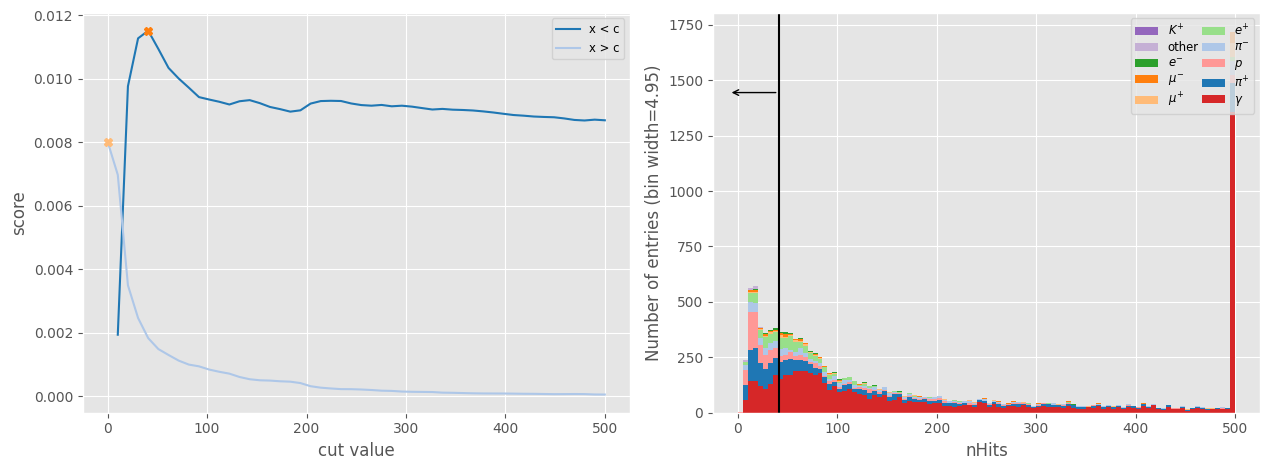

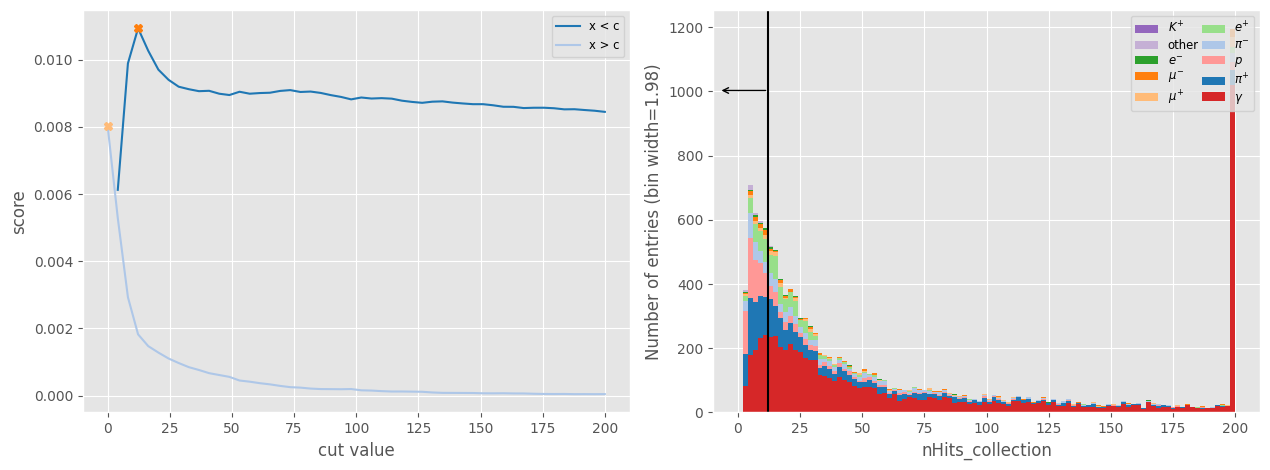

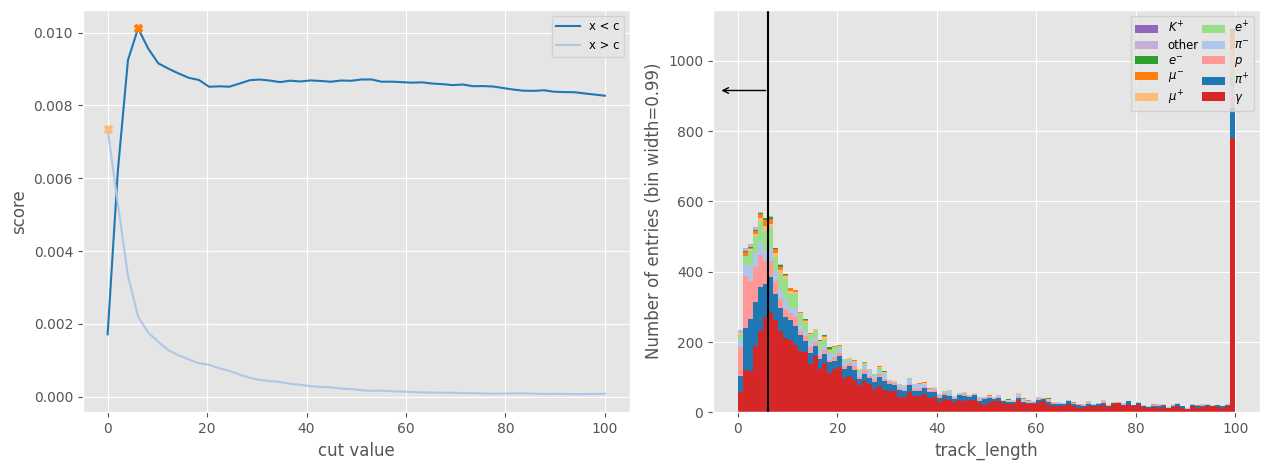

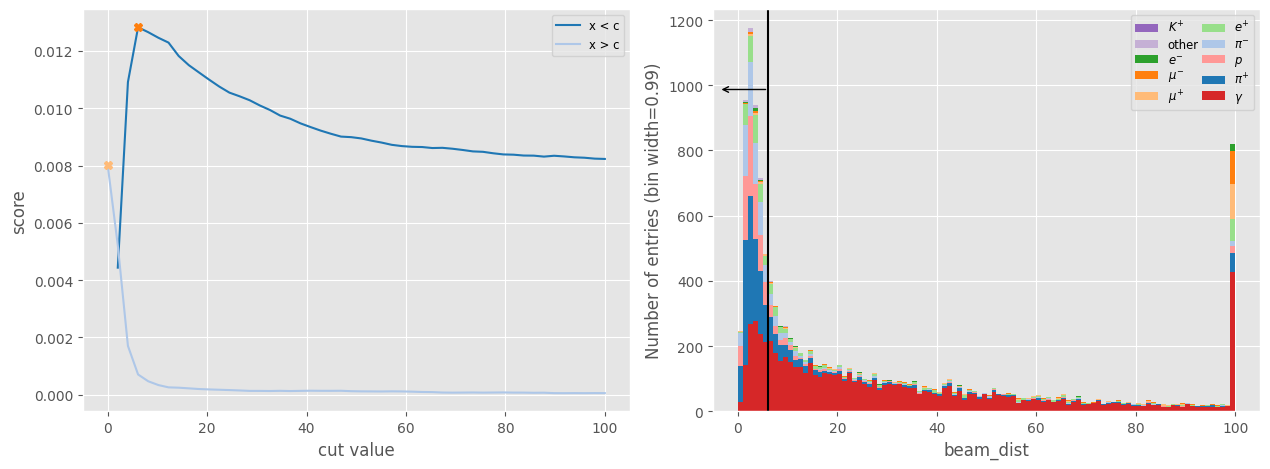

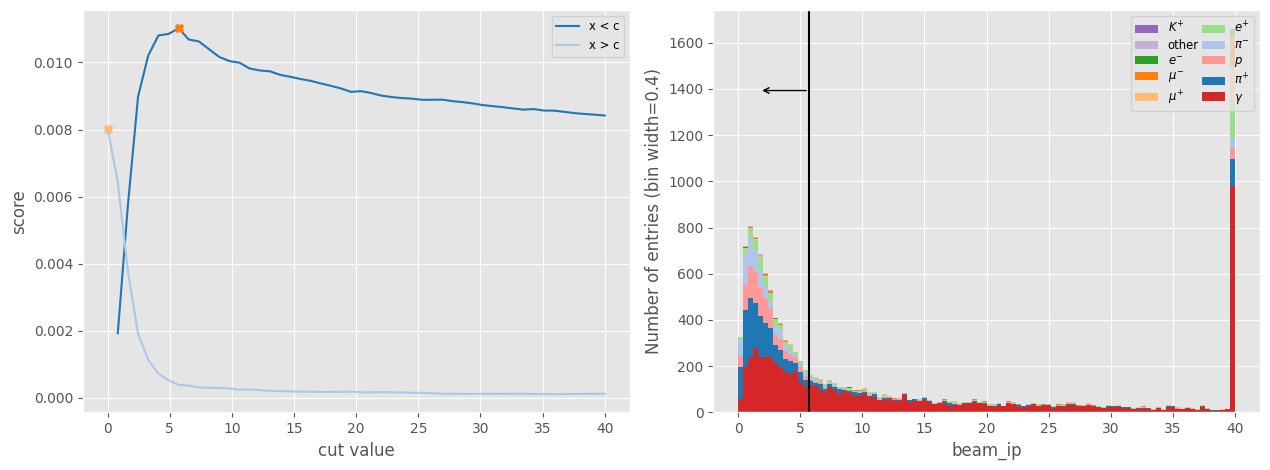

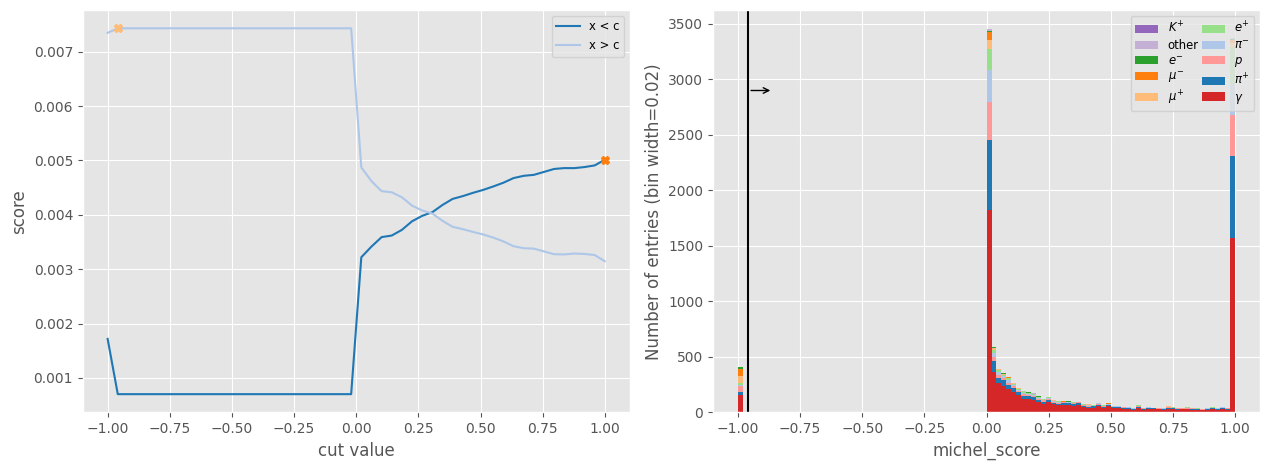

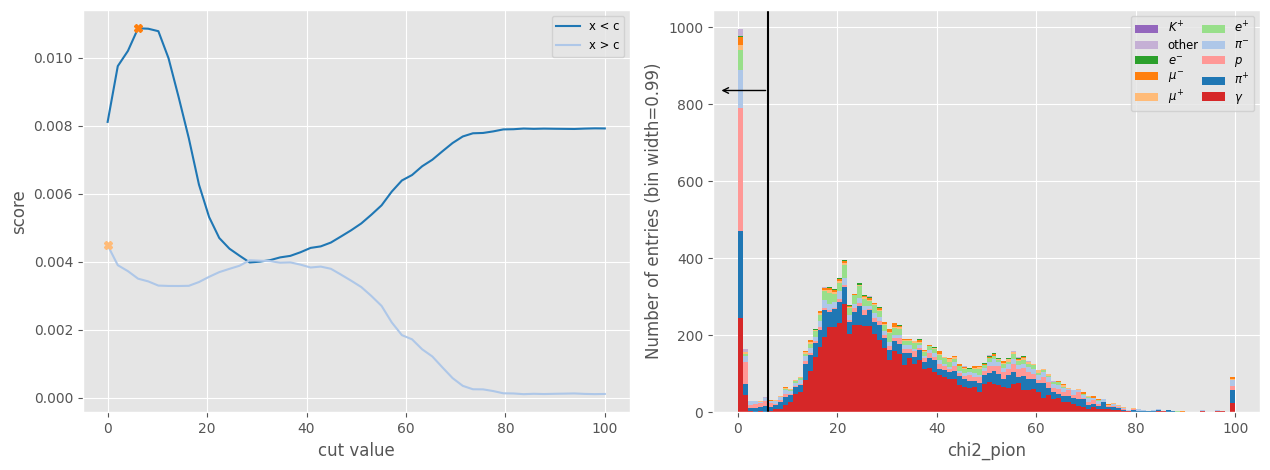

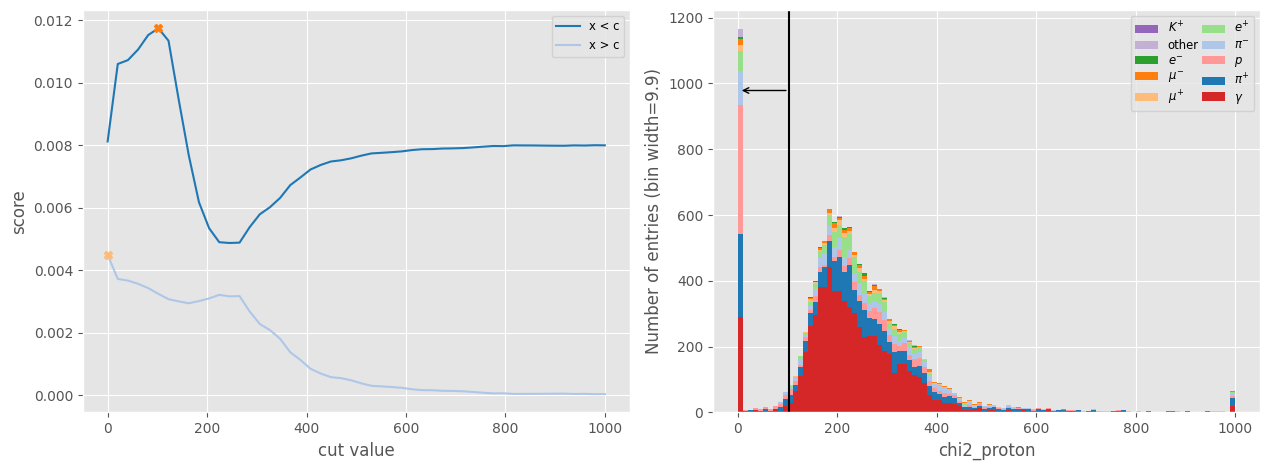

In [249]:
from python.analysis import SelectionTools
# cut_op = CutOptimiser(observables["beam_dist"][mask], pi, x_range = ranges["beam_dist"])
# beam_dist_cut = cut_op.Optimise(cut_op.pe)
# beam_dist_mask = SelectionTools.cuts_to_func(*beam_dist_cut)(observables["beam_dist"][mask])

# cut_op = CutOptimiser(observables["median_dEdX"][mask][beam_dist_mask], p[beam_dist_mask], x_range = ranges["median_dEdX"])
# median_dEdX_cut = cut_op.Optimise(cut_op.pe)
# median_dEdX_mask = ~SelectionTools.cuts_to_func(*median_dEdX_cut)(observables["median_dEdX"][mask])

# cut_op = CutOptimiser(observables["nHits_collection"][mask], gamma, x_range = ranges["nHits_collection"])
# nHits_collection_cut = cut_op.Optimise(cut_op.pe)
# nHits_collection_mask = ~SelectionTools.cuts_to_func(*nHits_collection_cut)(observables["nHits_collection"][mask])

# poor_pi_mask = beam_dist_mask & median_dEdX_mask & nHits_collection_mask


cut_op = CutOptimiser(observables["median_dEdX"][mask], p, x_range = ranges["median_dEdX"])
median_dEdX_cut = cut_op.Optimise(cut_op.pe)
median_dEdX_mask = ~SelectionTools.cuts_to_func(*median_dEdX_cut)(observables["median_dEdX"][mask])

cut_op = CutOptimiser(observables["beam_dist"][mask][median_dEdX_mask], pi[median_dEdX_mask], x_range = ranges["beam_dist"])
beam_dist_cut = cut_op.Optimise(cut_op.pe)
beam_dist_mask = SelectionTools.cuts_to_func(*beam_dist_cut)(observables["beam_dist"][mask])

cut_op = CutOptimiser(observables["track_score"][mask][median_dEdX_mask & beam_dist_mask], gamma[median_dEdX_mask & beam_dist_mask], x_range = ranges["track_score"])
track_score_cut = cut_op.Optimise(cut_op.pe)
track_score_mask = ~SelectionTools.cuts_to_func(*track_score_cut)(observables["track_score"][mask])

poor_pi_mask = median_dEdX_mask #& beam_dist_mask & track_score_mask

tags_poor_pi = Tags.GenerateTrueParticleTags(mc_beam)

for t in tags_poor_pi:
    tags_poor_pi[t].mask = tags_poor_pi[t].mask[mask][poor_pi_mask]

Plots.PlotTags(tags_poor_pi)

cut_op = CutOptimiser(None, p[poor_pi_mask])
for o in observables:
    cut_op.x = observables[o][mask][poor_pi_mask]
    cut_op.x_range = ranges[o]
    plot = Plots.MultiPlot(2)
    next(plot)
    results = cut_op.Optimise(cut_op.pe, plot = True)
    next(plot)
    cut_op.visualise(*results, tags = tags_poor_pi, x_label = o)

[[-0.47], [-0.131, 0.596, 1.14, 0.527, ... 0.856, 1.36, 1.12, 0.91, 0.881, -0.125]]


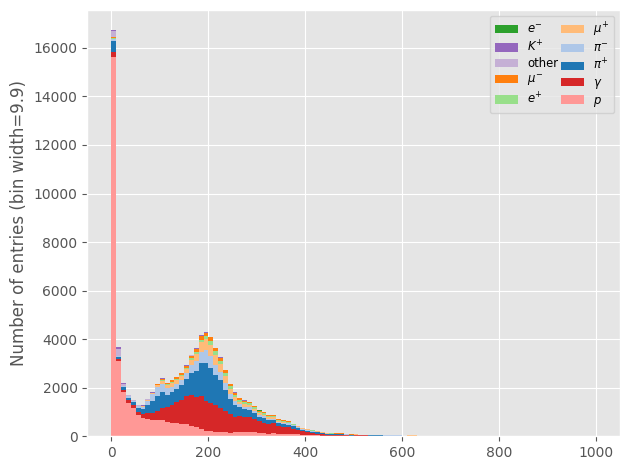

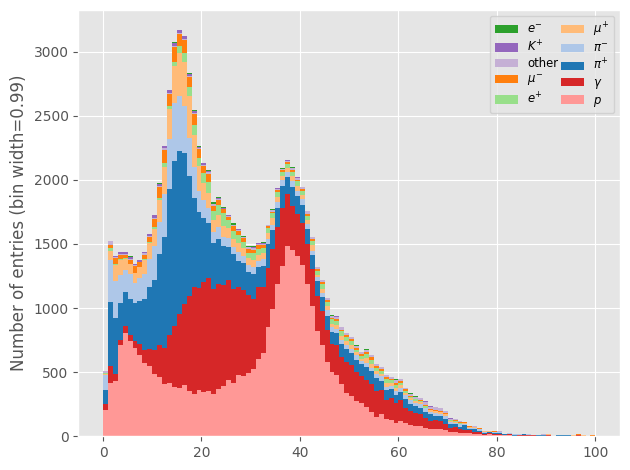

In [245]:
from python.analysis import vector

tags = Tags.GenerateTrueParticleTags(mc_beam)

dp = vector.dot(mc_beam.recoParticles.track_start_dir, vector.vector(1, 0, 1))
print(dp)

Plots.PlotTagged(mc_beam.recoParticles.track_chi2_proton / mc_beam.recoParticles.track_chi2_proton_ndof, tags, loc = "upper right", x_range = [0, 1000])
Plots.PlotTagged(mc_beam.recoParticles.track_chi2_pion / mc_beam.recoParticles.track_chi2_pion_ndof, tags, loc = "upper right", x_range = [0, 100])

In [ ]:
import itertools

with Plots.PlotBook("correlation_plots.pdf", True) as book:
    for _, c in Plots.IterMultiPlot(list(itertools.product(observables.keys(), repeat = 2)), threshold = 200):
        Plots.Plot(ak.ravel(observables[c[0]][mask][gamma]), ak.ravel(observables[c[1]][mask][gamma]), label = "$\gamma$", marker = "o", linestyle = "", newFigure = False, color = "C1", alpha = 0.33)
        Plots.Plot(ak.ravel(observables[c[0]][mask][p]), ak.ravel(observables[c[1]][mask][p]), label = "$p$", marker = "o", linestyle = "", newFigure = False, color = "C2", alpha = 0.33)
        Plots.Plot(ak.ravel(observables[c[0]][mask][pi]), ak.ravel(observables[c[1]][mask][pi]), label = "$\pi^{\pm}$", marker = "o", linestyle = "", newFigure = False, color = "C0", alpha = 0.33, xlabel = c[0], ylabel = c[1])
        Plots.plt.xlim(ranges[c[0]])
        Plots.plt.ylim(ranges[c[1]])
    book.Save()
    Plots.plt.close()

In [272]:
photon_mask = SelectionTools.CombineMasks(args.selection_masks["mc"]["photon"])
pi_mask = SelectionTools.CombineMasks(args.selection_masks["mc"]["pi"])

In [294]:
tags

{'$\\pi^{+}$': Tag(name='$\\pi^{+}$', name_simple='$\\pi^{+}$', colour='C0', mask=<Array [[False], ... False, False, False]] type='29452 * var * bool'>, number=0),
 '$\\pi^{-}$': Tag(name='$\\pi^{-}$', name_simple='$\\pi^{-}$', colour='C1', mask=<Array [[False], ... False, False, False]] type='29452 * var * bool'>, number=1),
 '$\\mu^{-}$': Tag(name='$\\mu^{-}$', name_simple='$\\mu^{-}$', colour='C2', mask=<Array [[False], ... False, False, False]] type='29452 * var * bool'>, number=2),
 '$\\mu^{+}$': Tag(name='$\\mu^{+}$', name_simple='$\\mu^{+}$', colour='C3', mask=<Array [[False], ... False, False, False]] type='29452 * var * bool'>, number=3),
 '$e^{-}$': Tag(name='$e^{-}$', name_simple='$e^{-}$', colour='C4', mask=<Array [[False], ... False, False, False]] type='29452 * var * bool'>, number=4),
 '$e^{+}$': Tag(name='$e^{+}$', name_simple='$e^{+}$', colour='C5', mask=<Array [[False], ... False, False, False]] type='29452 * var * bool'>, number=5),
 '$\\gamma$': Tag(name='$\\gamma$'

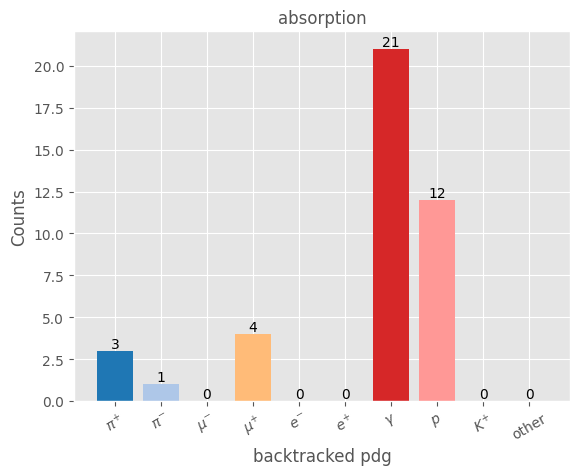

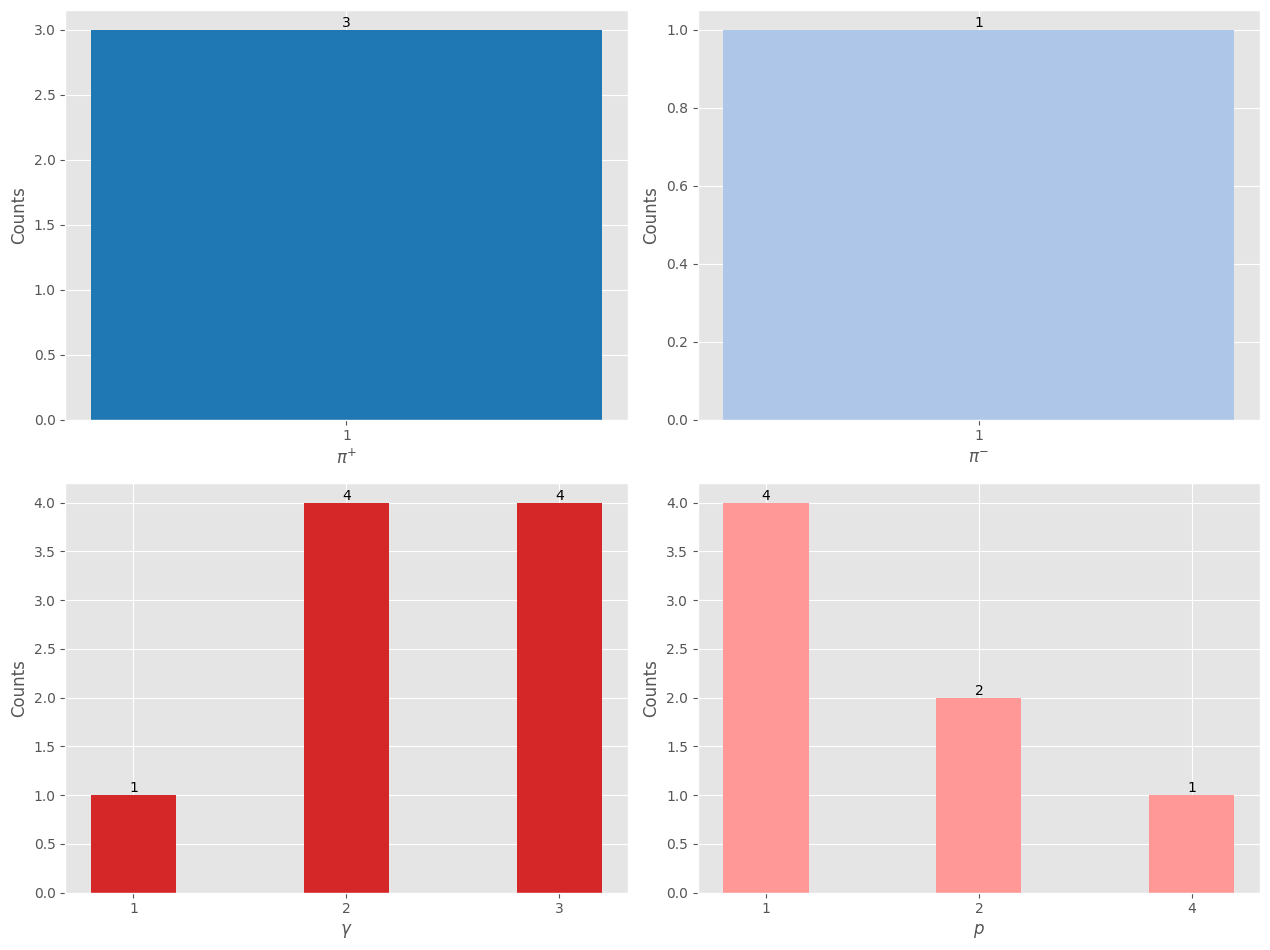

<Figure size 640x480 with 0 Axes>

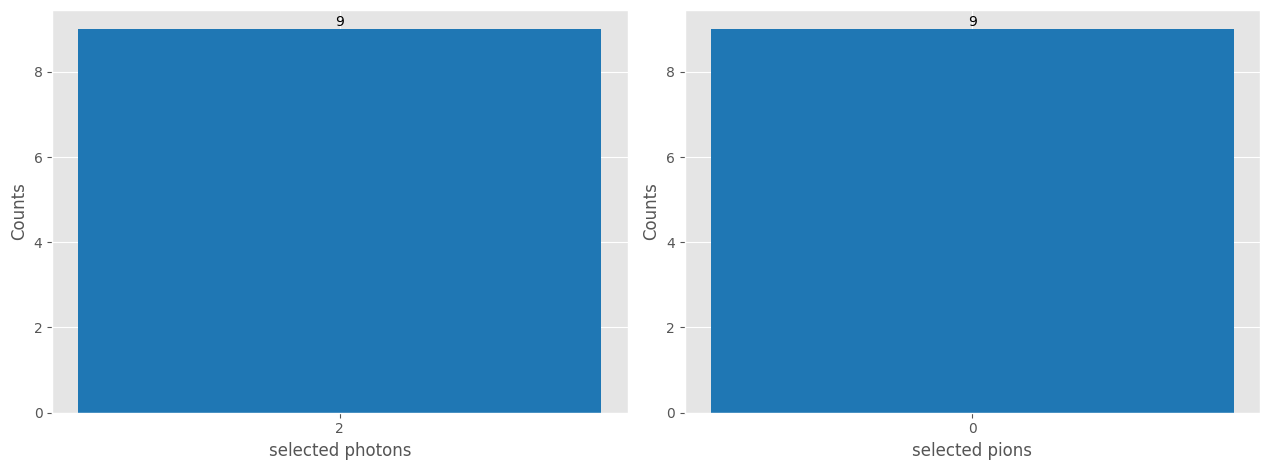

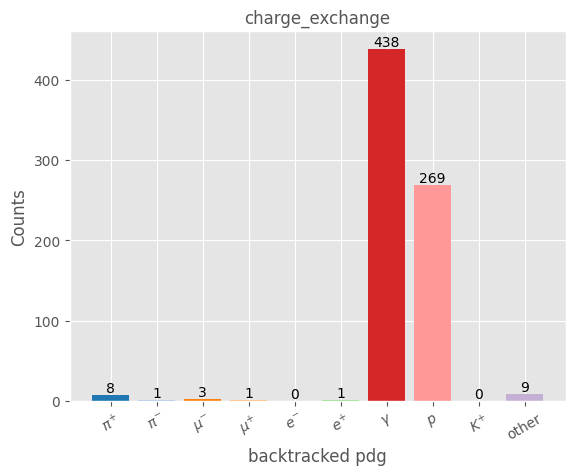

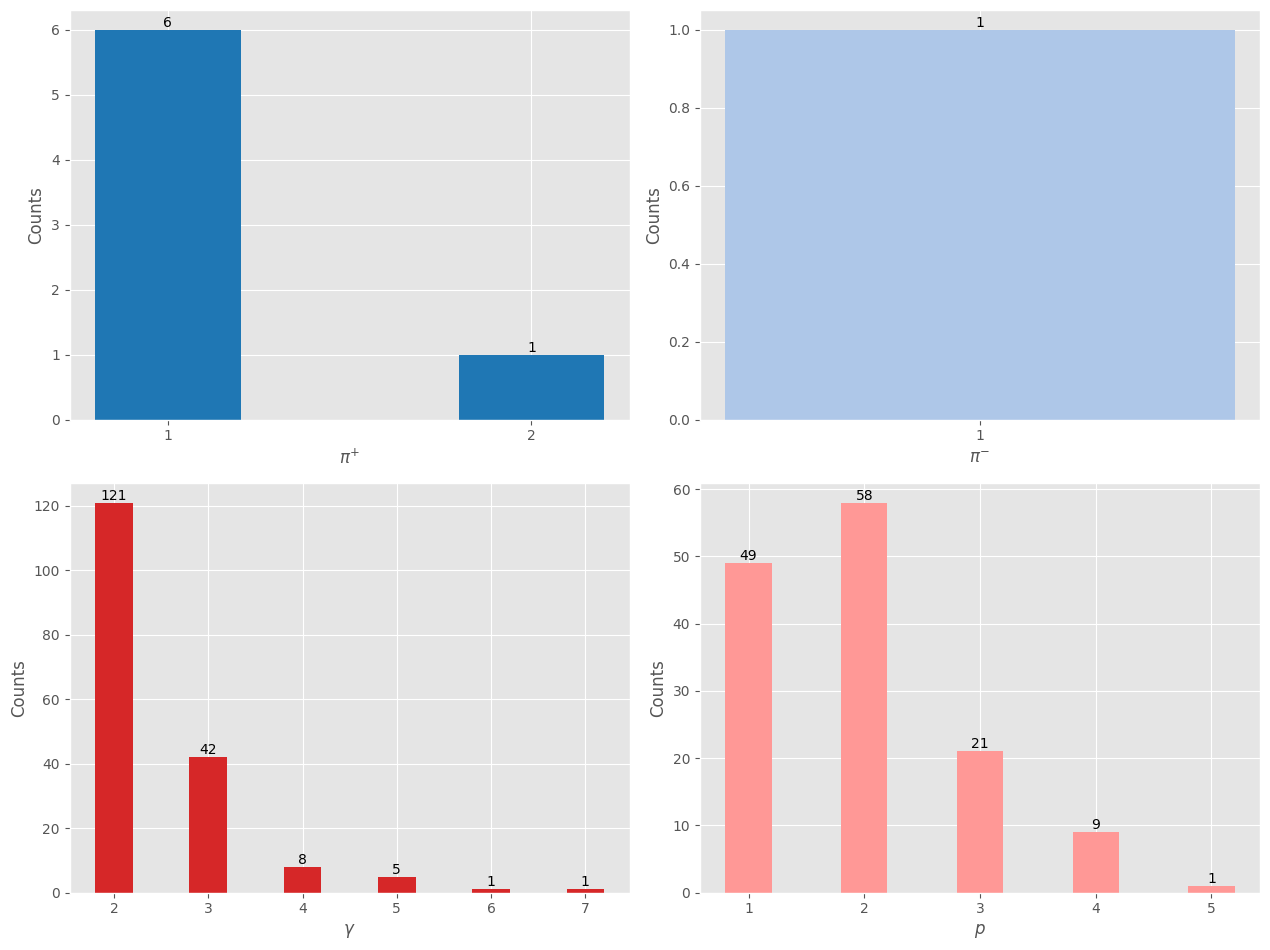

<Figure size 640x480 with 0 Axes>

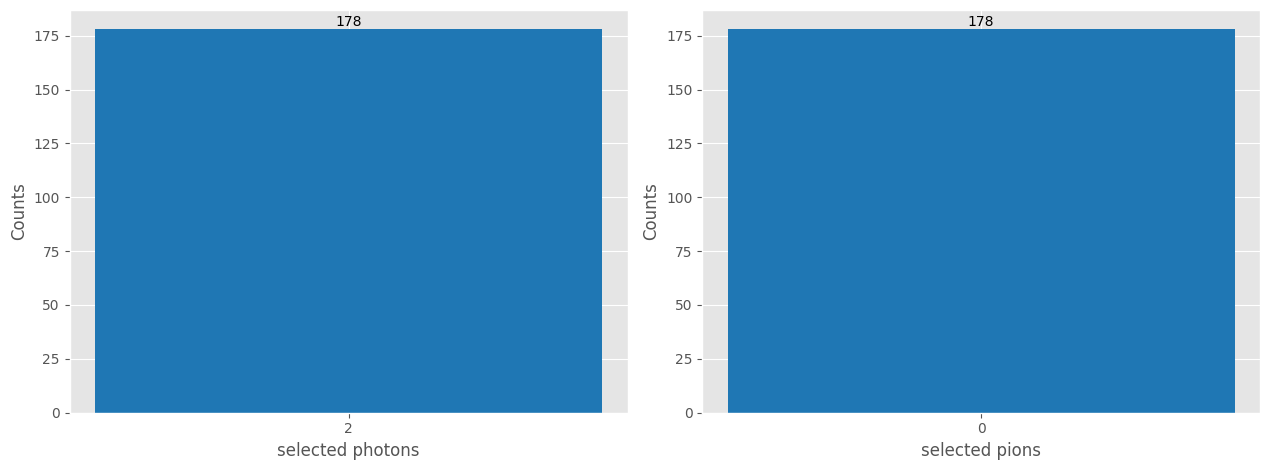

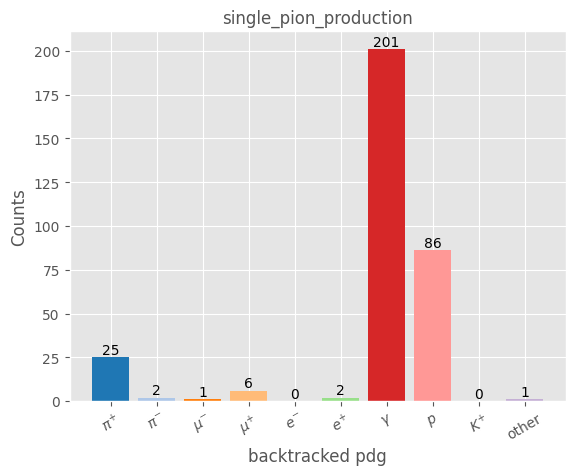

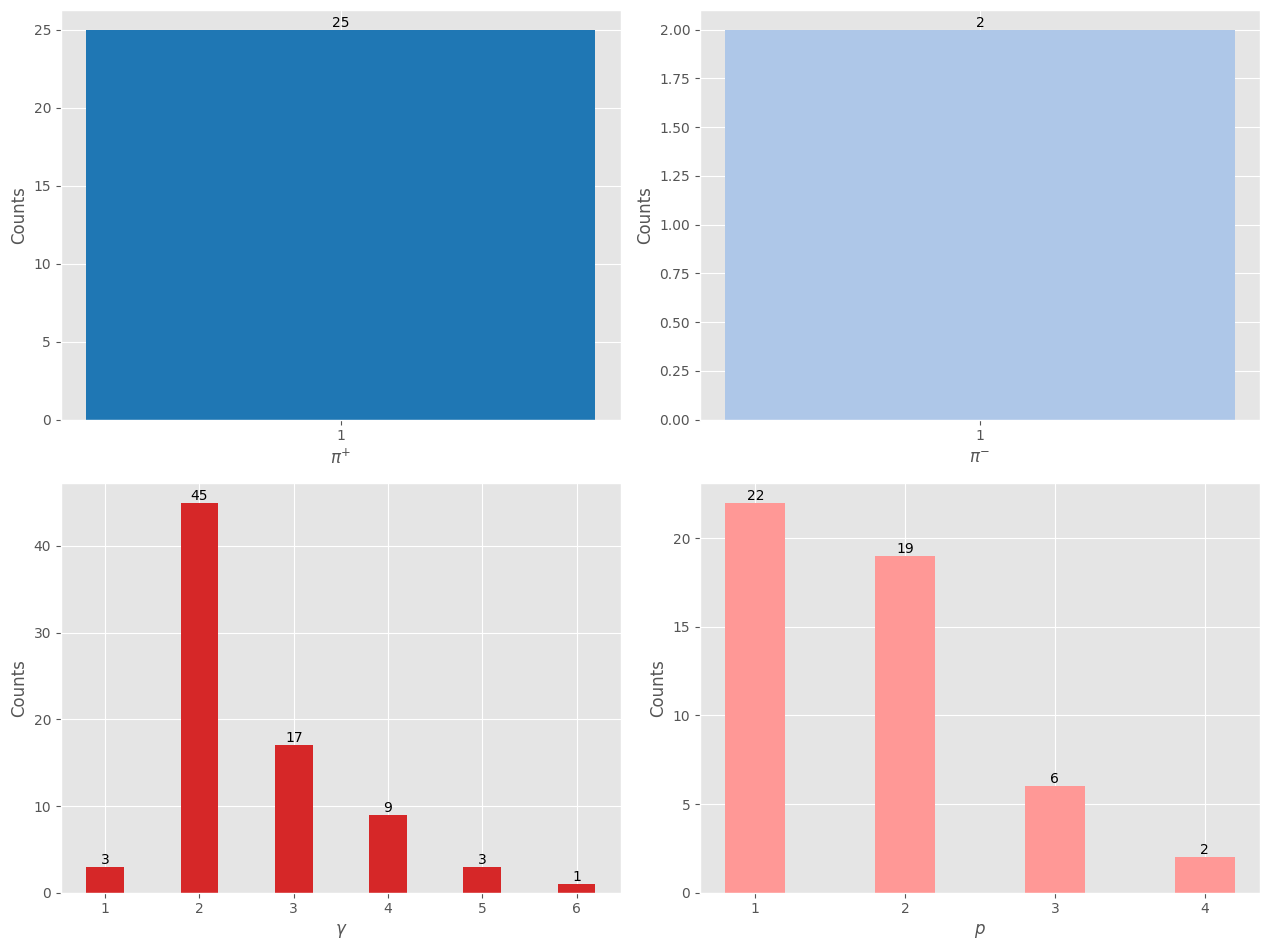

<Figure size 640x480 with 0 Axes>

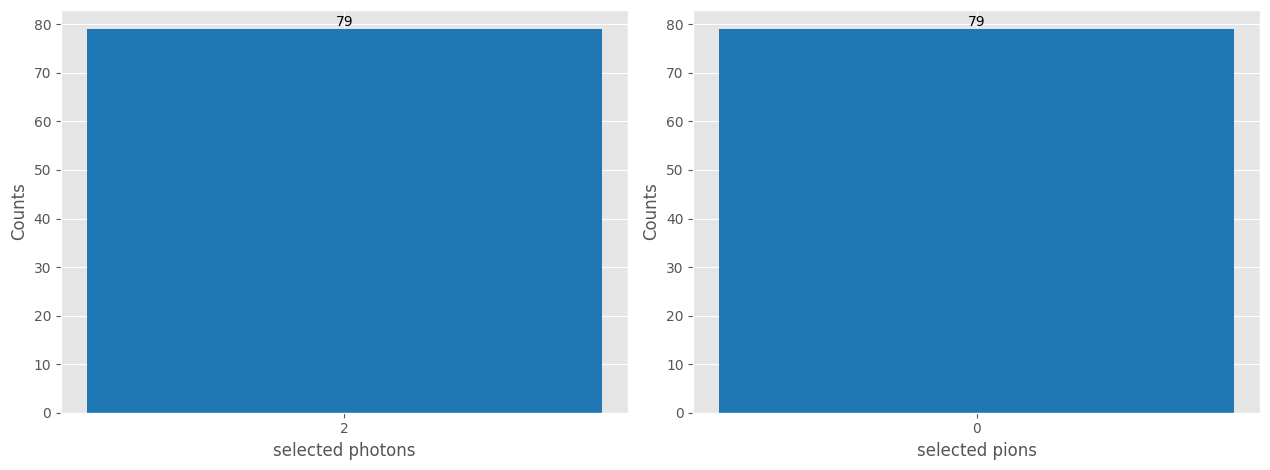

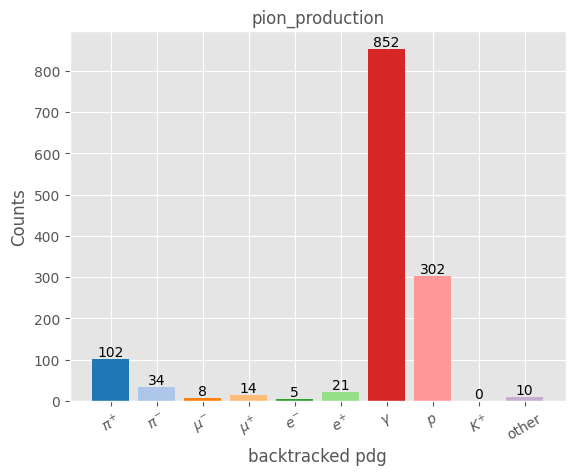

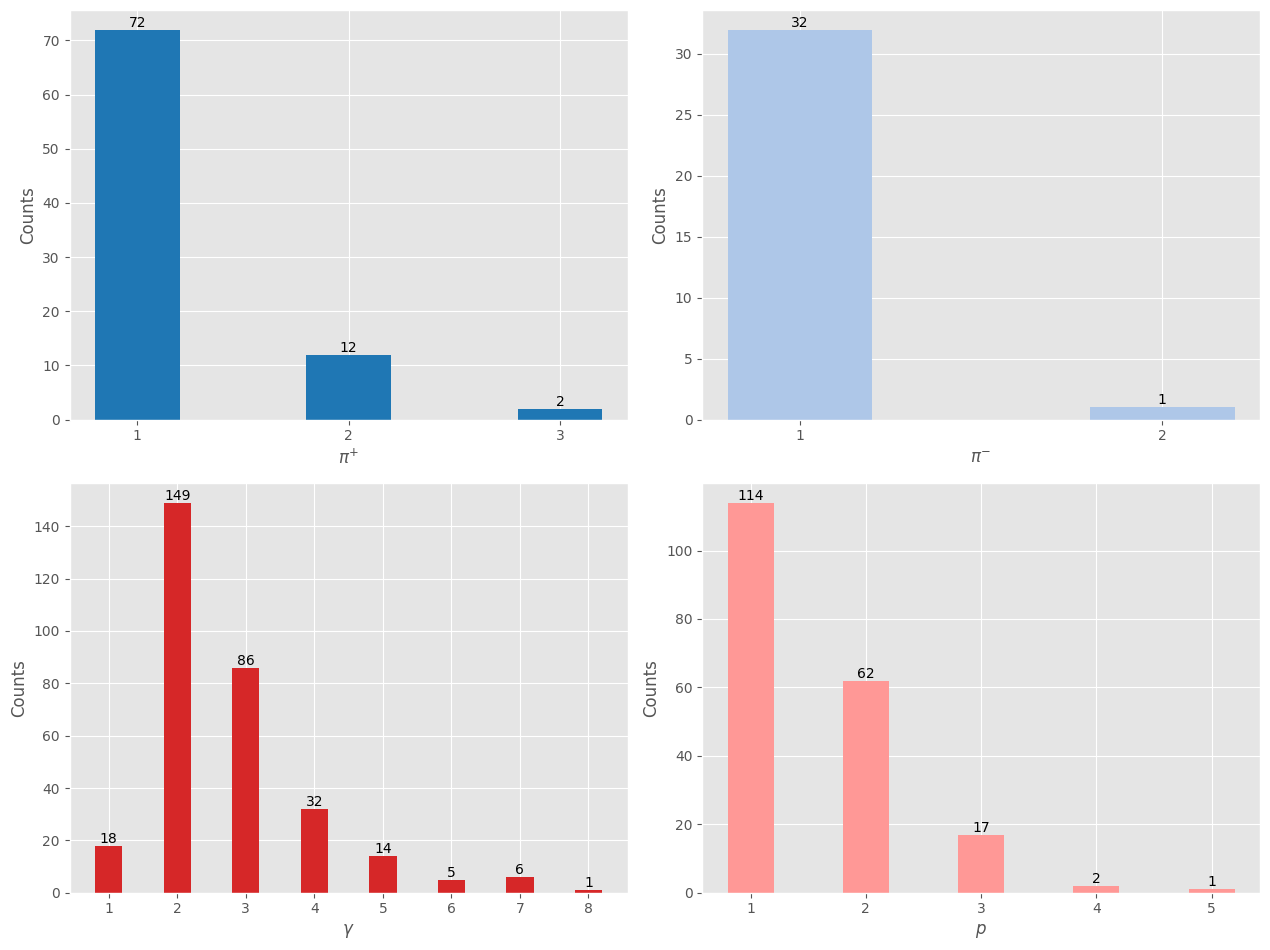

<Figure size 640x480 with 0 Axes>

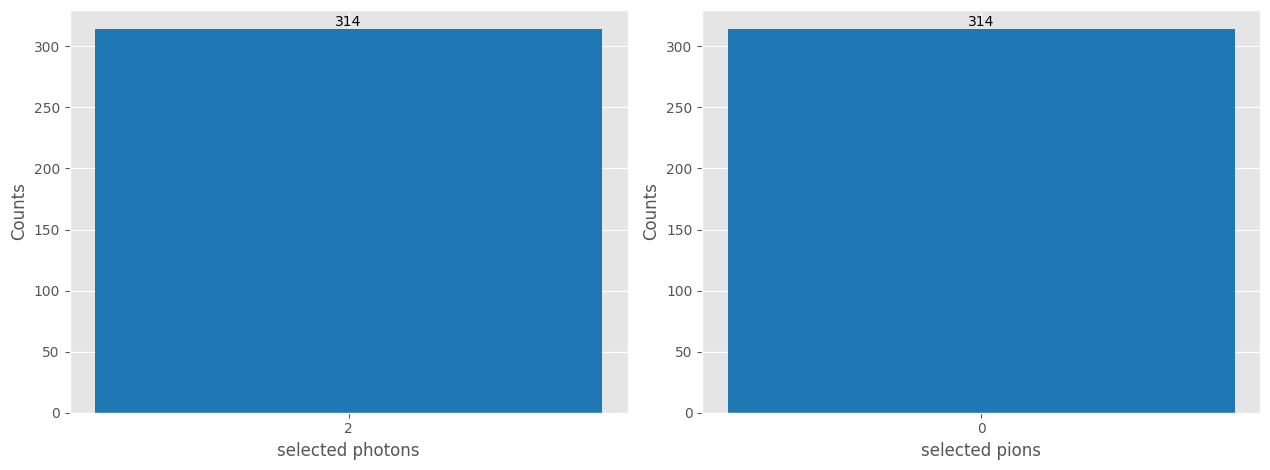

In [380]:
for t in true_regions:

    cell = true_regions[t] & reco_regions_op["charge_exchange"]

    tags = Tags.GenerateTrueParticleTags(mc_beam)
    tags_t = Tags.Tags()
    for i in tags:
        tags_t[i] = tags[i]
        tags_t[i].mask = tags_t[i].mask & cell #& ~(photon_mask | pi_mask)
    Plots.PlotTags(tags_t, xlabel = "backtracked pdg")
    Plots.plt.title(t)
    
    # Plots.plt.figure()
    for _, i in Plots.IterMultiPlot([0, 1, 6, 7]):
        n = ak.sum(tags_t.number[i].mask, -1)
        Plots.PlotBar(n[n > 0], xlabel = tags_t.number[i].name, color = tags_t.number[i].colour, newFigure = False)

    Plots.plt.figure()
    plot = Plots.MultiPlot(2)
    next(plot)
    Plots.PlotBar(ak.sum(photon_mask[cell], -1), xlabel = "selected photons", newFigure = False)
    next(plot)
    Plots.PlotBar(ak.sum(pi_mask[cell], -1), xlabel = "selected pions", newFigure = False)
    # Plots.PlotBar(ak.num(mc_beam.trueParticlesBT.number, -1)[true_regions[t] & reco_regions["absorption"]])

    # Plots.PlotBar(mc_beam.trueParticles.nProton[true_regions[t]], xlabel = "number of true protons")
    # Plots.PlotBar(mc_beam.trueParticles.nPi0[true_regions[t]], xlabel = "number of true pi0s")
    # Plots.PlotBar(mc_beam.trueParticles.nPiMinus[true_regions[t]] + mc_beam.trueParticles.nPiPlus[true_regions[t]], xlabel = "number of true charged pi")


28587
28587


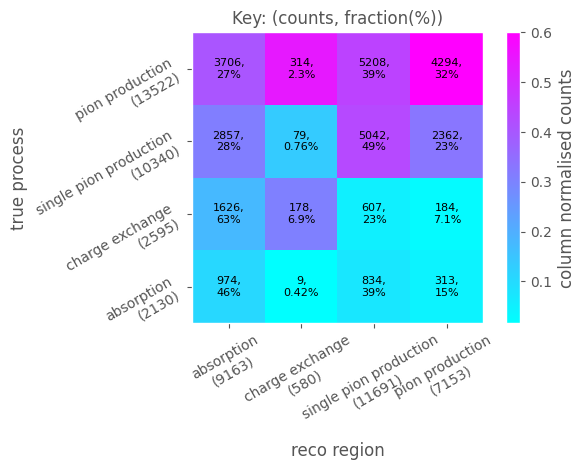

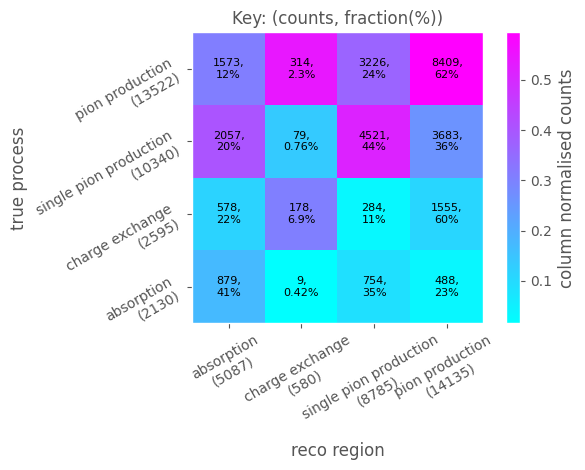

In [379]:
def create_regions_alt(pi0_counts, pi_charged_counts, photon_counts):
    regions_dict = {
        "absorption": (pi0_counts == 0) & (pi_charged_counts == 0) & (photon_counts == 0),
        "charge_exchange": (pi0_counts == 1) & (pi_charged_counts == 0),
        "single_pion_production": np.logical_and(np.logical_and(pi0_counts==0, pi_charged_counts==1), photon_counts == 0),
        "pion_production": ((pi0_counts >= 0) & (pi_charged_counts > 1)) | ((pi0_counts > 1) & (pi_charged_counts >= 0)) | ((pi0_counts == 1) & (pi_charged_counts == 1)) | ((pi0_counts == 0) & (pi_charged_counts <= 1) & (photon_counts > 0)),
    }
    return regions_dict

def create_regions_no_pi0(pi_charged_counts, photon_counts):
    regions_dict = {
        "absorption": (pi_charged_counts == 0) & (photon_counts < 1),
        "charge_exchange": (photon_counts > 1) & (pi_charged_counts == 0),
        "single_pion_production": (pi_charged_counts == 1) & (photon_counts < 1),
        # "pion_production": ((photon_counts >= 2) & (pi_charged_counts > 1)) | ((photon_counts > 2) & (pi_charged_counts >= 0)) | ((photon_counts == 2) & (pi_charged_counts == 1)),
        # "pion_production": (photon_counts == 2) & (pi_charged_counts == 1)
    }
    regions_dict["pion_production"] = ~(regions_dict["absorption"] | regions_dict["charge_exchange"] | regions_dict["single_pion_production"])
    return regions_dict


n_pi =  SelectionTools.GetPFOCounts(args.selection_masks["mc"]["pi"])
n_pi0 = SelectionTools.GetPFOCounts(args.selection_masks["mc"]["pi0"])
n_photon = SelectionTools.GetPFOCounts(args.selection_masks["mc"]["photon"])

reco_regions_op = create_regions_alt(n_pi0, n_pi, n_photon)
# reco_regions_no_pi0 = create_regions_no_pi0(n_pi, n_photon)

counts_op = cross_section.Toy.ComputeCounts(true_regions, reco_regions_op)
counts_nominal = cross_section.Toy.ComputeCounts(true_regions, reco_regions)
# counts_no_pi0 = cross_section.Toy.ComputeCounts(true_regions, reco_regions_no_pi0)

Plots.PlotConfusionMatrix(counts_nominal, list(reco_regions.keys()), list(true_regions.keys()), y_label = "true process", x_label = "reco region")
Plots.PlotConfusionMatrix(counts_op, list(reco_regions.keys()), list(true_regions.keys()), y_label = "true process", x_label = "reco region")
# Plots.PlotConfusionMatrix(counts_no_pi0, list(reco_regions.keys()), list(true_regions.keys()), y_label = "true process", x_label = "reco region")

print(np.sum(counts_op))
print(np.sum(counts_nominal))
# print(np.sum(counts_no_pi0))